In [27]:
import imaging_behavior_functions
import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json

In [5]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/mbon_imaging/MBON09/"
example_path_data = base_path+"20220824-3_FR1_GCAMP7f_short/data/"
example_path_results = base_path+"20220824-3_FR1_GCAMP7f_short/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [26]:
behav_df

time        fwV      sideV       yawV   heading   abssideV  \
0       0.000000   0.000000   0.000000   0.000000  3.649735   0.000000   
1       0.240357   2.103080  -1.550447  -3.233444  3.442509   1.550447   
2       0.480714   1.338724   1.652632  -1.149402  3.451238   1.652632   
3       0.721071   0.892131   1.070527  -0.297418  3.461337   1.070527   
4       0.961428   4.949189  -2.221138  -3.085217  3.437699   2.221138   
...          ...        ...        ...        ...       ...        ...   
1493  358.852825   7.395114  22.044332   2.682459  5.619302  22.044332   
1494  359.093182  10.516962  29.038056  11.432193  6.123378  29.038056   
1495  359.333538   2.657580 -11.716866  -4.080048  0.084908  11.716866   
1496  359.573895   9.848312 -15.641416 -21.411968  5.427036  15.641416   
1497  359.814252   2.740443   7.079909   1.938118  5.014100   7.079909   

        absyawV  net_motion  net_motion_state  heading_adj        xPos  \
0      0.000000    0.000000                 0     3.649735    0.000000   
1      3.233444    6.886971                 1     3.442509   -0.119998   
2      1.149402    4.140758                 1     3.451238   -0.166173   
3      0.297418    2.260076                 1     3.461337   -0.194972   
4      3.085217   10.255544                 1     3.437699   -0.468065   
...         ...         ...               ...          ...         ...   
1493   2.682459   32.121905                 1   -38.362995  980.939485   
1494  11.432193   50.987212                 1   -37.858919  982.440929   
1495   4.080048   18.454493                 1   -37.614204  982.781644   
1496  21.411968   46.901695                 1   -38.555261  984.936918   
1497   1.938118   11.758470                 1   -38.968197  984.936918   

           yPos  
0      0.000000  
1      0.470164  
2      0.811594  
3      1.038943  
4      2.166649  
...         ...  
1493 -56.561681  
1494 -59.090650  
1495 -59.466218  
1496 -59.704407  
1497 -59.704407  

[1498 rows x 12 columns]

In [24]:
# https://jdblischak.github.io/fucci-seq/circ-simulation-correlation.html
def calc_circular_correlation(circular_series, series2):
    circular_series_cos = np.cos(circular_series)
    circular_series_sin = np.sin(circular_series)
    correlation_cos = series2.corr(pd.Series(circular_series_cos))
    correlation_sin = series2.corr(pd.Series(circular_series_sin))
    correlation_cs = pd.Series(circular_series_cos).corr(pd.Series(circular_series_sin))
    numerator = correlation_cos**2 + correlation_sin**2-2*correlation_cos*correlation_sin*correlation_cs
    denominator = 1- correlation_cs**2
    combined_correlation = np.sqrt(numerator/denominator)
    return combined_correlation

In [207]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/hDeltaB_imaging/qualified_sessions/odor_trials/"
summary_stats_path = base_path+'summary_stats.json'
with open(summary_stats_path, 'r', encoding='utf-8') as jsonfile:
    corr_dict = json.load(jsonfile)
corr_dict

{'phase': [0.2949552348448164,
  0.26249917312218085,
  0.3779856314217626,
  0.28904009263028346,
  0.04397012470389224,
  0.1907364057812106,
  0.029447379388664204,
  0.19549537621480226,
  0.3323283515461304,
  0.48216486376065454,
  0.2692644433033963,
  0.06695173389481025,
  0.1550953116021683,
  0.2680310366627854,
  0.47011407169808067,
  0.1780870615497677,
  0.12108836521914312,
  0.26343413361428986,
  0.33638904815377296,
  0.17056216982240302,
  0.43113770018327824,
  0.22862032363276957,
  0.15460096800730203,
  0.13307453113275663,
  0.2592499003192434,
  0.5148435588500848,
  0.1895104799171345,
  0.13132940349918903,
  0.27277692122485675,
  0.1679705144513182,
  0.10640297475189889],
 'amplitude': [0.4309297983719327,
  0.34790209393681315,
  0.4677273496079656,
  0.38878684033387717,
  0.09059431261998353,
  0.02542896172403854,
  -0.24166415664065463,
  -0.15447306908827704,
  0.3340965361509377,
  0.05674387108410396,
  0.2758929885721832,
  0.3374842842618652,
  

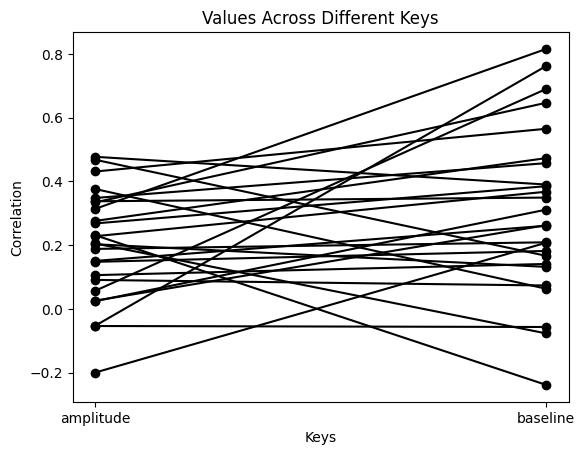

In [234]:

# Prepare the plot
fig, ax = plt.subplots()

# Extract keys and values
keys = list(corr_dict.keys())[1:]
values = [corr_dict[key] for key in keys]

# Number of samples (assuming all lists are the same length)
num_samples = len(values[0])
skip_list = [3,6,7,25,26,29]
# Plot each sample
for i in range(num_samples):
    # Extract the ith value from each key's list
    sample_values = [values[j][i] for j in range(len(keys))]
    
    # Plot points and connect them with lines
    color = 'black'
    #if i in range(26,28):
        #color = 'red'
    if i in skip_list:
        continue
    else:
        ax.plot(keys, sample_values, marker='o', linestyle='-', color = color,label=f'Sample {i+1}')

# Adding legend, titles and labels
ax.set_xlabel('Keys')
ax.set_ylabel('Correlation')
ax.set_title('Values Across Different Keys')
#ax.legend(title="Sample ID")

# Show the plot
plt.show()


0
1
2
4
5
8
9
10
11
12
13
14
15
18
19
23
27
28
30


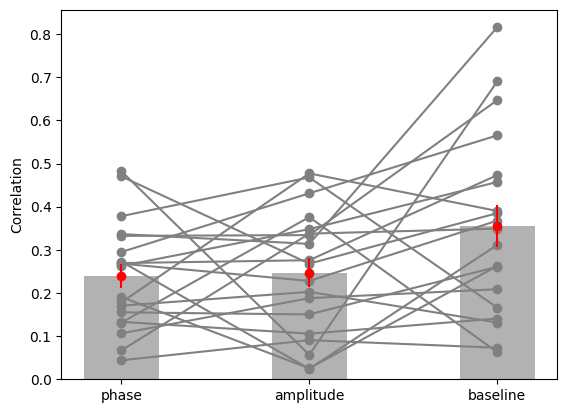

In [257]:
# Prepare the plot
fig, ax = plt.subplots()

# Extract keys and values
keys = list(corr_dict.keys())
values = [corr_dict[key] for key in keys]

# Number of samples (assuming all lists are the same length)
num_samples = len(values[0])
skip_list = [3,6,7,16,17,20,21,22,24,25,26,29]

filtered_values = []
for val_list in values:
    # Using a list comprehension to filter out indices in the skip_list
    filtered_values.append([val for idx, val in enumerate(val_list) if idx not in skip_list])

# Calculate means and standard errors excluding the skip list
means = [np.mean(v) for v in filtered_values]
std_errors = [np.std(v, ddof=1) / np.sqrt(len(v)) for v in filtered_values]

# Plot each sample
for i in range(num_samples):
    # Extract the ith value from each key's list
    sample_values = [values[j][i] for j in range(len(keys)) if i not in skip_list]
    #print(sample_values)
    
    if i not in skip_list and all(x > 0 for x in sample_values):
        print(i)
        ax.plot(keys, sample_values, marker='o', color='gray')

# Add bar graph for the mean of each key's values
#ax2 = ax.twinx()  # Create a twin y-axis to plot the bar graph
ax.bar(keys, means, alpha=0.6, color='gray', label='Mean', width=0.4)
ax.errorbar(keys, means, yerr=std_errors, fmt='o', color='red', label='Standard Error')

# Adding legends, titles, and labels
#ax.set_xlabel('Keys')
ax.set_ylabel('Correlation')
#ax2.set_ylabel('Mean Values')
#ax.set_title('Values Across Different Keys')

#fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

# Show the plot
plt.show()


In [193]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/hDeltaB_imaging/qualified_sessions/odor_trials/"
hdf5_file_path = base_path + 'pds_all_flies.h5'
example_df = pd.read_hdf(hdf5_file_path, key='20230928-3_MBON09hDeltaB_syntGCAMP7f_20secodor_40isi_trial1')
example_df

time        fwV      sideV       yawV   heading   abssideV  \
0       0.000000   0.000000   0.000000   0.000000  5.539280   0.000000   
1       0.240513   3.652445 -12.403834   4.665923  5.779628  12.403834   
2       0.481026   1.242206   4.971620  -0.247012  5.796273   4.971620   
3       0.721539   3.820885  -5.312250  -0.462036  5.866794   5.312250   
4       0.962052   2.910143 -10.987517   1.568462  5.960732  10.987517   
...          ...        ...        ...        ...       ...        ...   
2698  648.903982  -1.556478   1.453559  -0.295244  5.609043   1.453559   
2699  649.144495  -1.211541  27.281485 -15.648567  5.158154  27.281485   
2700  649.385008  -1.897732 -43.000571  -1.803965  4.881100  43.000571   
2701  649.625521  12.026803  80.730766 -10.594134  4.568520  80.730766   
2702  649.866034  -0.607259  14.605898  -5.152215  4.138818  14.605898   

        absyawV  net_motion  net_motion_state  heading_adj  ...  hDeltaB_14  \
0      0.000000    0.000000                 0     5.539280  ...    0.046477   
1      4.665923   20.722203                 1     5.779628  ...    0.092096   
2      0.247012    6.460838                 1     5.796273  ...    0.143786   
3      0.462036    9.595171                 1     5.866794  ...    0.166299   
4      1.568462   15.466122                 1     5.960732  ...    0.155712   
...         ...         ...               ...          ...  ...         ...   
2698   0.295244    3.305281                 1    68.440897  ...   -0.093478   
2699  15.648567   44.141593                 1    67.990007  ...   -0.115265   
2700   1.803965   46.702268                 1    67.712953  ...   -0.022676   
2701  10.594134  103.351703                 1    67.400373  ...    0.215634   
2702   5.152215   20.365371                 1    66.970671  ...    0.403930   

      hDeltaB_15  hDeltaB_16  hDeltaB_17     phase  baseline  amplitude  \
0      -0.037389    0.045128    0.065513  2.587194 -0.189234   1.451666   
1      -0.005833    0.025009    0.072501  2.587194 -0.063082   1.584850   
2       0.050166   -0.009406    0.087494  2.587194  0.077070   1.685354   
3       0.093174   -0.017915    0.106903  2.587194  0.191042   1.762409   
4       0.112342    0.040911    0.176212  2.587194  0.236406   1.747673   
...          ...         ...         ...       ...       ...        ...   
2698    0.093009    0.387912    0.705226  1.478397 -0.313014   3.076299   
2699    0.079280    0.324773    0.733516  1.478397 -0.252647   3.084734   
2700    0.185979    0.465020    0.863567  1.108797 -0.105880   2.812042   
2701    0.411583    0.724216    1.150421  1.108797  0.144257   2.295259   
2702    0.578847    0.904462    1.385683  0.739198  0.292547   1.928387   

      phase_error  baseline_error  amplitude_error  
0        0.083417        0.085015         0.119359  
1        0.080047        0.088885         0.124532  
2        0.077966        0.091742         0.128064  
3        0.076071        0.093386         0.130035  
4        0.074348        0.090538         0.126117  
...           ...             ...              ...  
2698     0.042730        0.095110         0.137492  
2699     0.046061        0.102913         0.148917  
2700     0.043545        0.088513         0.127843  
2701     0.050290        0.082790         0.118714  
2702     0.077216        0.105602         0.149784  

[2703 rows x 39 columns]

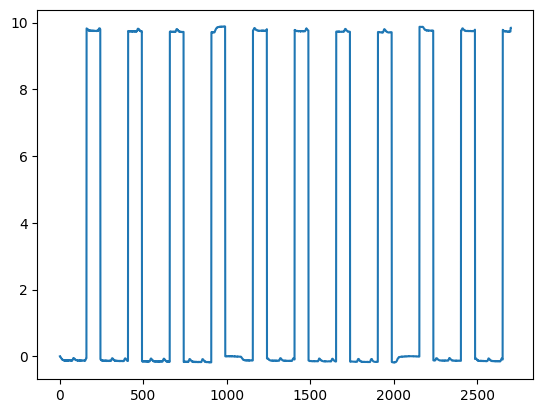

In [194]:
plt.plot(example_df.odor)

In [195]:
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

In [196]:
filtered_columns = [col for col in example_df.columns if 'hDeltaB' in col]
for col in filtered_columns:
    example_df[col] = min_max_normalize(example_df[col])

In [197]:
example_df

time        fwV      sideV       yawV   heading   abssideV  \
0       0.000000   0.000000   0.000000   0.000000  5.539280   0.000000   
1       0.240513   3.652445 -12.403834   4.665923  5.779628  12.403834   
2       0.481026   1.242206   4.971620  -0.247012  5.796273   4.971620   
3       0.721539   3.820885  -5.312250  -0.462036  5.866794   5.312250   
4       0.962052   2.910143 -10.987517   1.568462  5.960732  10.987517   
...          ...        ...        ...        ...       ...        ...   
2698  648.903982  -1.556478   1.453559  -0.295244  5.609043   1.453559   
2699  649.144495  -1.211541  27.281485 -15.648567  5.158154  27.281485   
2700  649.385008  -1.897732 -43.000571  -1.803965  4.881100  43.000571   
2701  649.625521  12.026803  80.730766 -10.594134  4.568520  80.730766   
2702  649.866034  -0.607259  14.605898  -5.152215  4.138818  14.605898   

        absyawV  net_motion  net_motion_state  heading_adj  ...  hDeltaB_14  \
0      0.000000    0.000000                 0     5.539280  ...    0.245532   
1      4.665923   20.722203                 1     5.779628  ...    0.273096   
2      0.247012    6.460838                 1     5.796273  ...    0.304328   
3      0.462036    9.595171                 1     5.866794  ...    0.317931   
4      1.568462   15.466122                 1     5.960732  ...    0.311534   
...         ...         ...               ...          ...  ...         ...   
2698   0.295244    3.305281                 1    68.440897  ...    0.160969   
2699  15.648567   44.141593                 1    67.990007  ...    0.147804   
2700   1.803965   46.702268                 1    67.712953  ...    0.203748   
2701  10.594134  103.351703                 1    67.400373  ...    0.347740   
2702   5.152215   20.365371                 1    66.970671  ...    0.461512   

      hDeltaB_15  hDeltaB_16  hDeltaB_17     phase  baseline  amplitude  \
0       0.164836    0.185629    0.147408  2.587194 -0.189234   1.451666   
1       0.185126    0.171778    0.149934  2.587194 -0.063082   1.584850   
2       0.221133    0.148085    0.155352  2.587194  0.077070   1.685354   
3       0.248786    0.142227    0.162366  2.587194  0.191042   1.762409   
4       0.261110    0.182726    0.187413  2.587194  0.236406   1.747673   
...          ...         ...         ...       ...       ...        ...   
2698    0.248680    0.421622    0.378589  1.478397 -0.313014   3.076299   
2699    0.239852    0.378153    0.388813  1.478397 -0.252647   3.084734   
2700    0.308458    0.474708    0.435811  1.108797 -0.105880   2.812042   
2701    0.453516    0.653154    0.539474  1.108797  0.144257   2.295259   
2702    0.561063    0.777246    0.624494  0.739198  0.292547   1.928387   

      phase_error  baseline_error  amplitude_error  
0        0.083417        0.085015         0.119359  
1        0.080047        0.088885         0.124532  
2        0.077966        0.091742         0.128064  
3        0.076071        0.093386         0.130035  
4        0.074348        0.090538         0.126117  
...           ...             ...              ...  
2698     0.042730        0.095110         0.137492  
2699     0.046061        0.102913         0.148917  
2700     0.043545        0.088513         0.127843  
2701     0.050290        0.082790         0.118714  
2702     0.077216        0.105602         0.149784  

[2703 rows x 39 columns]

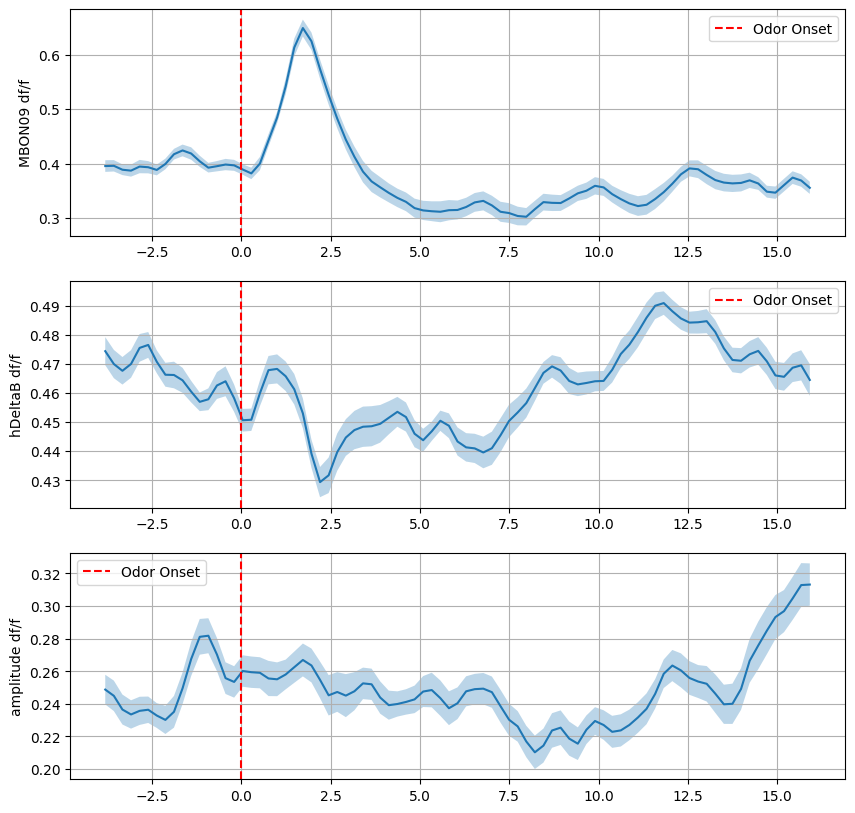

In [201]:
def plot_average_odor_response(df,roi_kw,roi_kw2=None,ax=None,minmax_norm = False):
    """
    Plots average odor response for MBON09 columns aligned to odor on time.
    
    Parameters:
    - df: DataFrame with columns 'time', 'odor', and several 'MBON09...' columns.
    """
    roi_columns = [col for col in df.columns if roi_kw in col]
    if minmax_norm:
        for col in roi_columns:
            df[col] = min_max_normalize(df[col])
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    # Calculate mean across all MBON09 columns
    df[roi_kw+'_mean'] = df[roi_columns].mean(axis=1)
    #df[roi_kw2+'_mean'] = df[mbon_columns].mean(axis=1)
    # Filter rows where odor is on (odor > 5)
    #odor_on = df['odor'].copy()
    
    # Determine changes in the 'odor' status to find onset
    df['odor'] = df['odor'].astype(int)
    df['odor_change'] = df['odor'].diff()
    start_times = df[df['odor_change'] > 5]['time'].values
    end_times = df[df['odor_change'] < -5]['time'].values
    if len(end_times) == len(start_times)-1: 
        end_times = np.append(end_times,df.time[len(df)-1])
    #print(start_times)
    if len(end_times) != len(start_times): 
        return
    #print(end_times)
    is_valid = end_times - start_times >= 3
    
    # Collect valid periods (start time + 10 seconds must be within the DataFrame time range)
    valid_responses = []
    plt_time = []
    for i, start_time in enumerate(start_times):
        # Define the analysis window from 5s before to 10s after the start
        if is_valid[i]:
            period_start = start_time - 5
            period_end = start_time + 15
            
            # Check if the period is within the DataFrame's time range
            if period_end <= df['time'].iloc[-1] and period_start >= df['time'].iloc[0]:
                # Extract the period
                period_mask = (df['time'] >= period_start) & (df['time'] <= period_end)
                period_data = df.loc[period_mask, roi_kw+'_mean']  # Using the mean column
                
                if not period_data.empty:
                    # Adjust time to be zero at odor onset
                    period_data.index = df.loc[period_mask, 'time'] - start_time +1
                    #print(period_data.)
                    plt_time.append(np.array(period_data.index))
                    valid_responses.append(np.array(period_data))

    # Calculate average response across all valid periods
    if valid_responses:
        #print(valid_responses)
        # Plotting
        odor_error = np.std(valid_responses,axis=0)/len(valid_responses)
        #plt.figure(figsize=(5, 5))
        #average_response.plot()
        ax.plot(np.mean(plt_time,axis=0) , np.mean(valid_responses,axis=0))
        ax.fill_between(np.mean(plt_time,axis=0) , np.mean(valid_responses,axis=0)-odor_error,np.mean(valid_responses,axis=0)+odor_error,alpha=0.3)
        ax.axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        #plt.title('Average MBON09 Response Aligned to Odor Onset')
        #ax.xlabel('Time from Odor Onset (s)')
        ax.set_ylabel(roi_kw +' df/f')
        ax.legend()
        ax.grid(True)
        #ax.show()
    else:
        print("No valid odor periods found.")

# Example usage
# Assuming 'df' is your DataFrame loaded with appropriate data
fig, ax = plt.subplots(3,1,figsize=(10,10))
kws = ['MBON09','hDeltaB','amplitude']
for i in range(len(ax)):
    plot_average_odor_response(example_df,kws[i],ax=ax[i],minmax_norm=True)


In [189]:
np.mean(example_df.odor[0:100]) 

0.0

Processing /20221011-3_hDeltaBMBON09_syntGCAMP7f_odor_trial1...
No valid odor periods found.
No valid odor periods found.
No valid odor periods found.
Processing /20221011-3_hDeltaBMBON09_syntGCAMP7f_odor_trial2...
No valid odor periods found.
No valid odor periods found.
No valid odor periods found.
Processing /20221011-3_hDeltaBMBON09_syntGCAMP7f_odor_trial3...
No valid odor periods found.
No valid odor periods found.
No valid odor periods found.
Processing /20221011-3_hDeltaBMBON09_syntGCAMP7f_odor_trial4...
No valid odor periods found.
No valid odor periods found.
No valid odor periods found.
Processing /20221027-1_hDeltaBMBON09_GCAMP7f_odor_trial1...
No valid odor periods found.
No valid odor periods found.
No valid odor periods found.
Processing /20221027-1_hDeltaBMBON09_GCAMP7f_odor_trial2...
No valid odor periods found.
No valid odor periods found.
No valid odor periods found.
Processing /20221027-1_hDeltaBMBON09_GCAMP7f_odor_trial3...
No valid odor periods found.
No valid odor

C:\Users\wilson\AppData\Local\Temp\ipykernel_15448\1960862487.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(3,1,figsize=(10,10))


Processing /20230901-1_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_trial1...
Processing /20230901-2_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_flipaxis_trial1...
Processing /20230901-3_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_flipaxis_flipsign_trial1...
Processing /20230901-4_MBON09hDeltaB_syntGCAMP7f_apple_sigmoid_fly2_flipaxis_flipsign_trial1...
Processing /20230919-5_MBON09hDeltaB_syntGCAMP7f_test_sigmoid_trial1...
Processing /20230919-5_MBON09hDeltaB_syntGCAMP7f_test_sigmoid_trial2...
Processing /20230919-5_MBON09hDeltaB_syntGCAMP7f_test_sigmoid_trial3...
Processing /20230919-5_MBON09hDeltaB_syntGCAMP7f_test_sigmoid_trial4...
Processing /20230919-5_MBON09hDeltaB_syntGCAMP7f_test_sigmoid_trial5...
Processing /20230927-4_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi_trial1...
Processing /20230927-6_MBON09hDeltaB_syntGCAMP7f_20secodor_40isi_trial1...
Processing /20230927-6_MBON09hDeltaB_syntGCAMP7f_20secodor_40isi_trial2...
Processing /20230928-1_MBON09hDeltaB_syntGCAMP7f_10secodor_30isi_trial1..

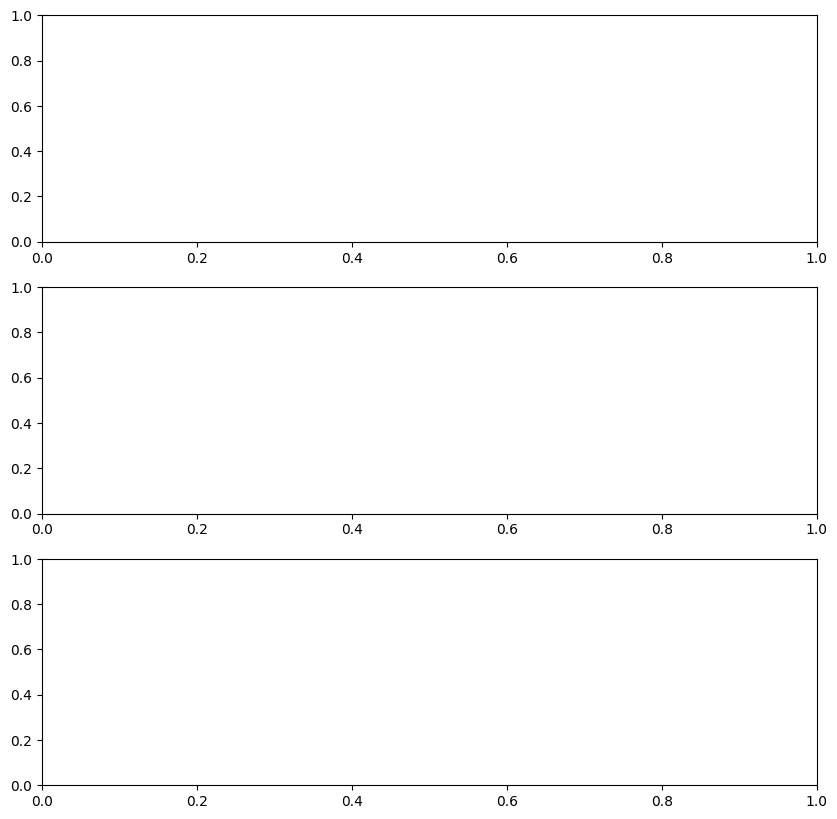

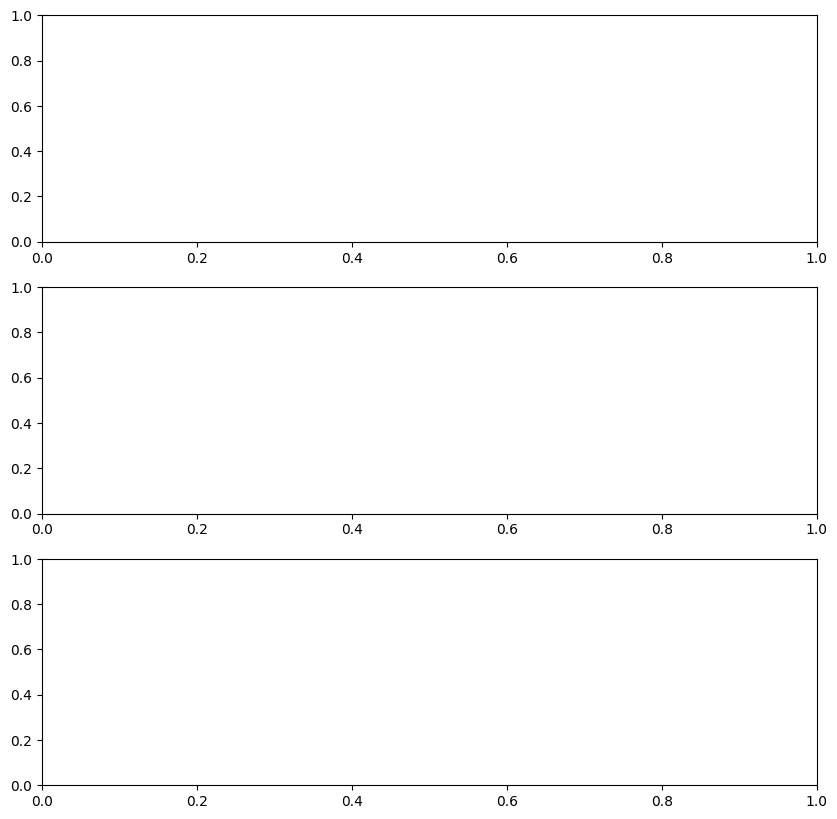

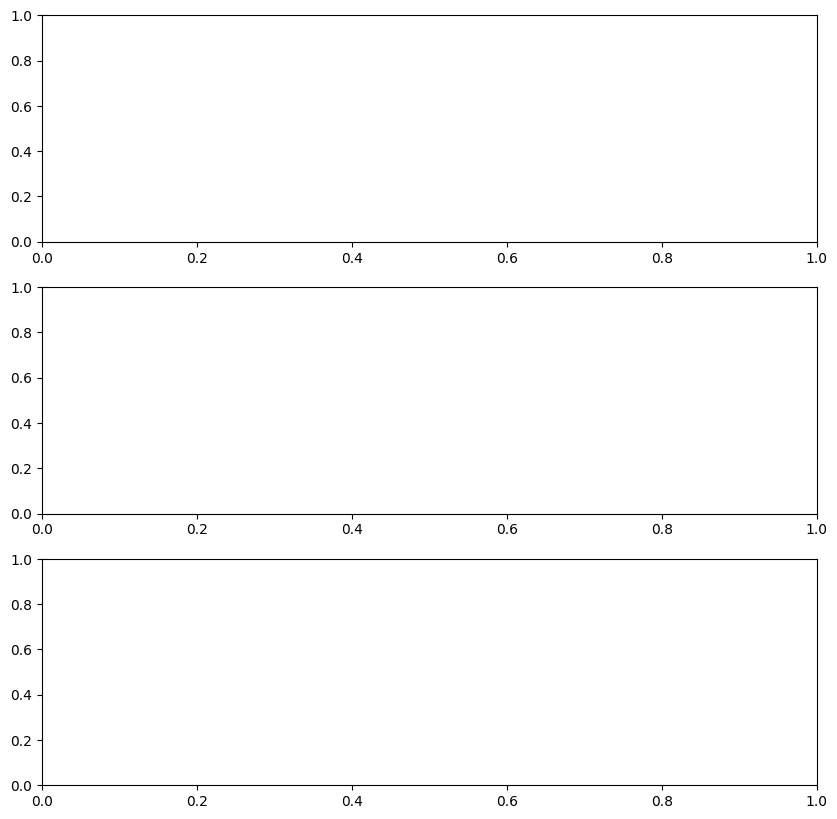

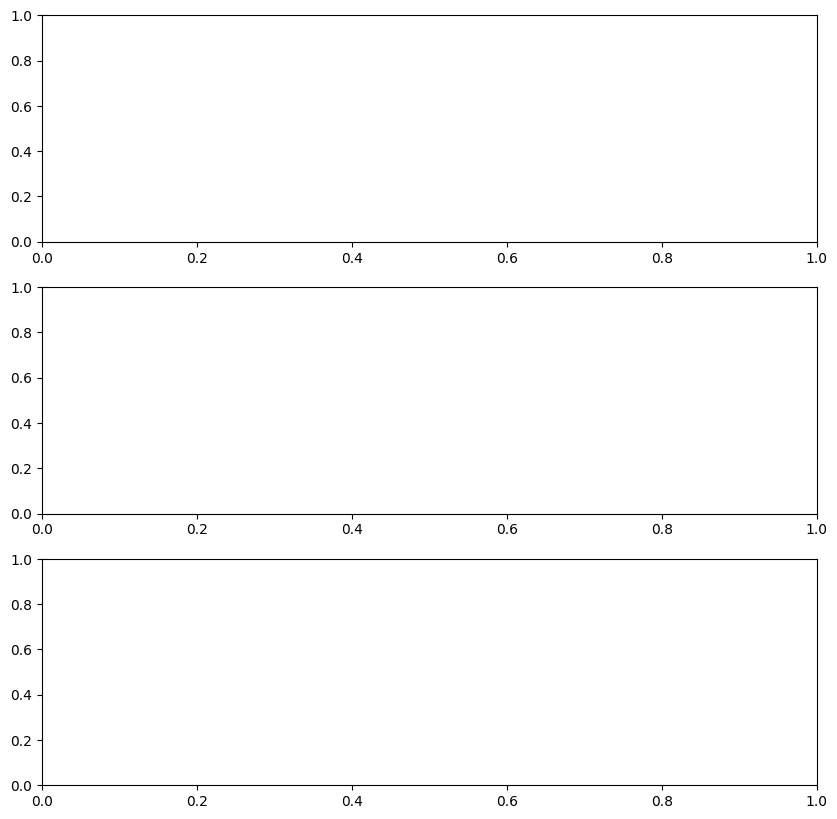

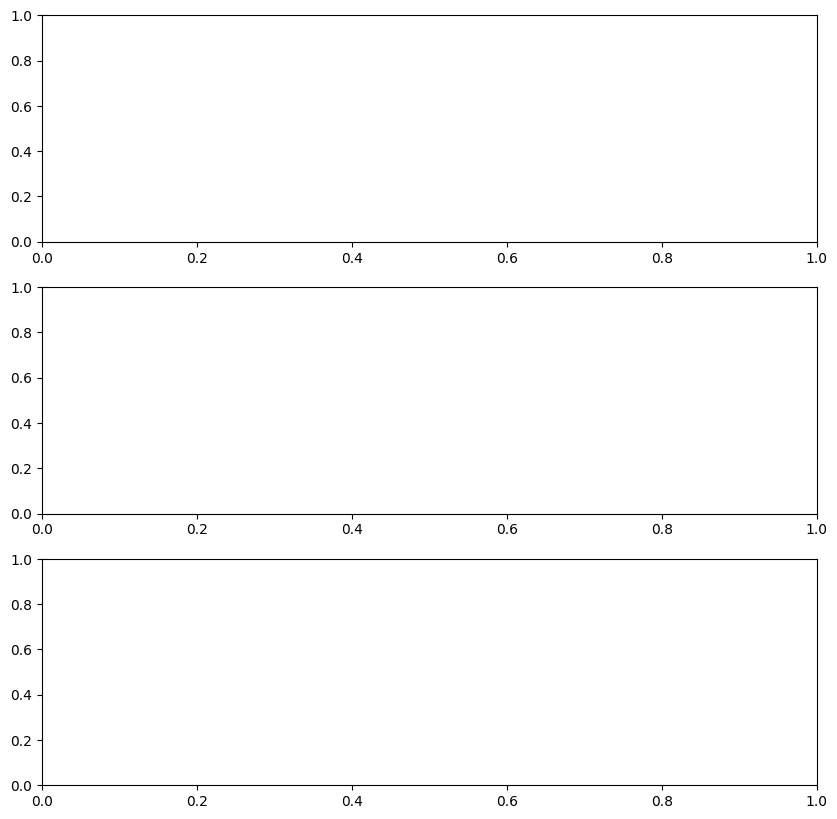

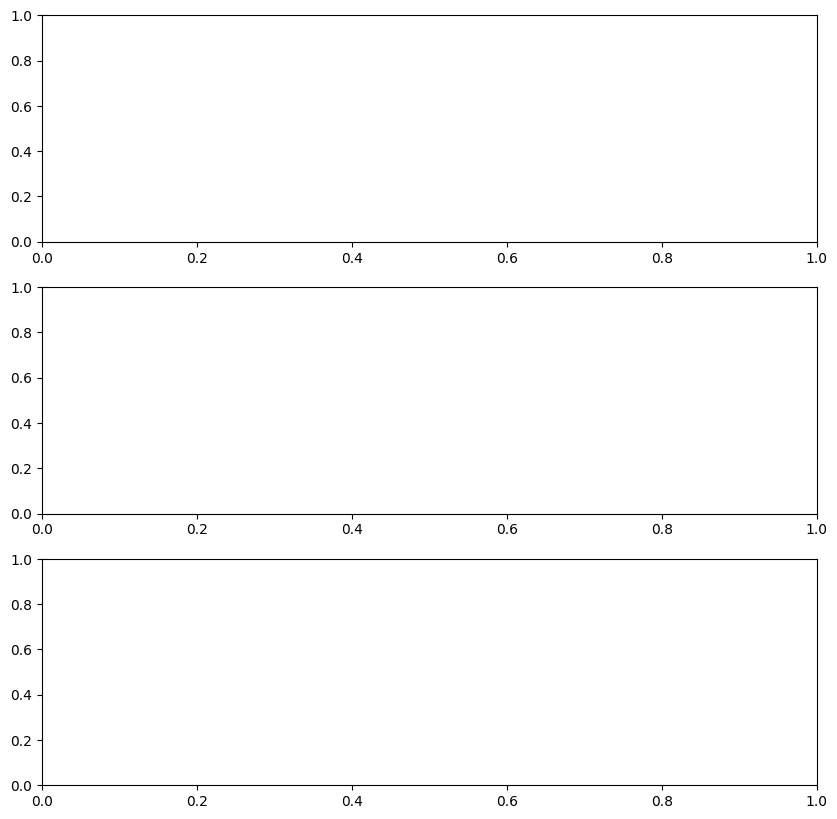

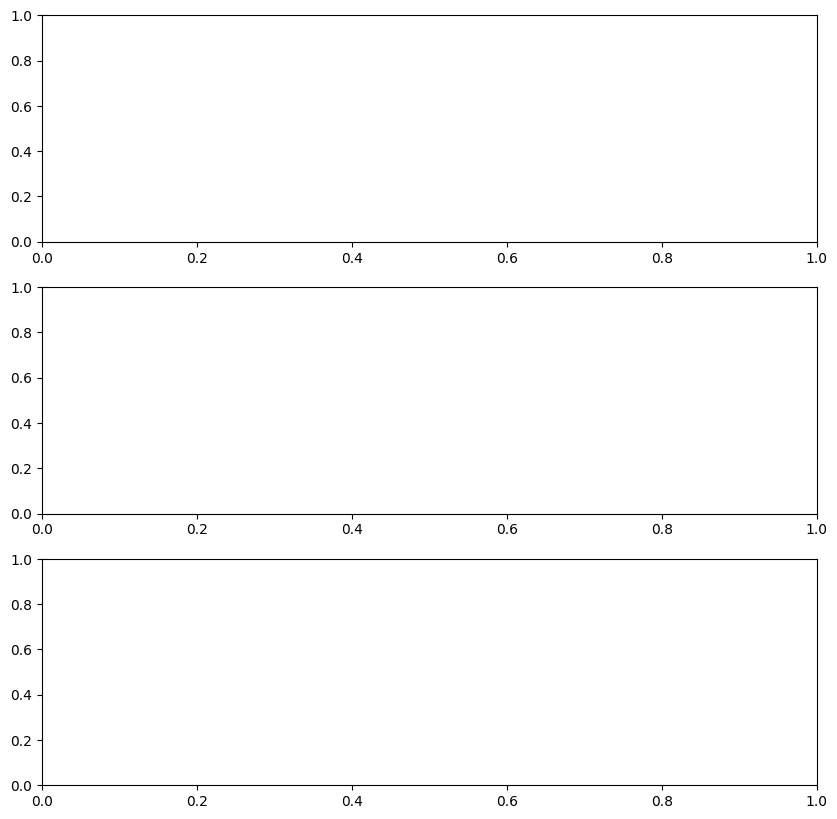

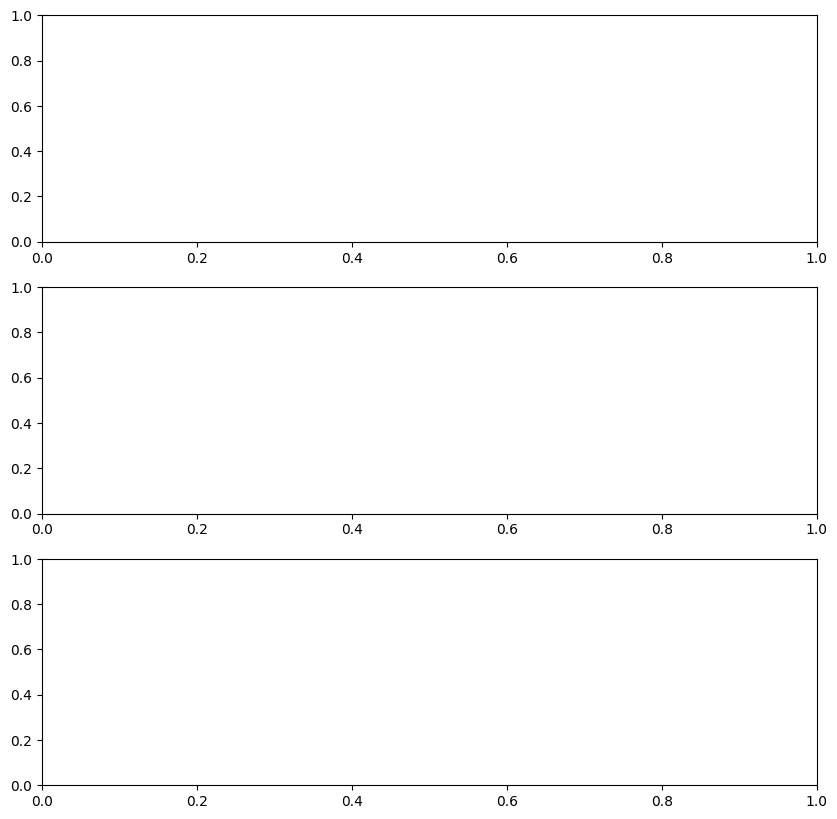

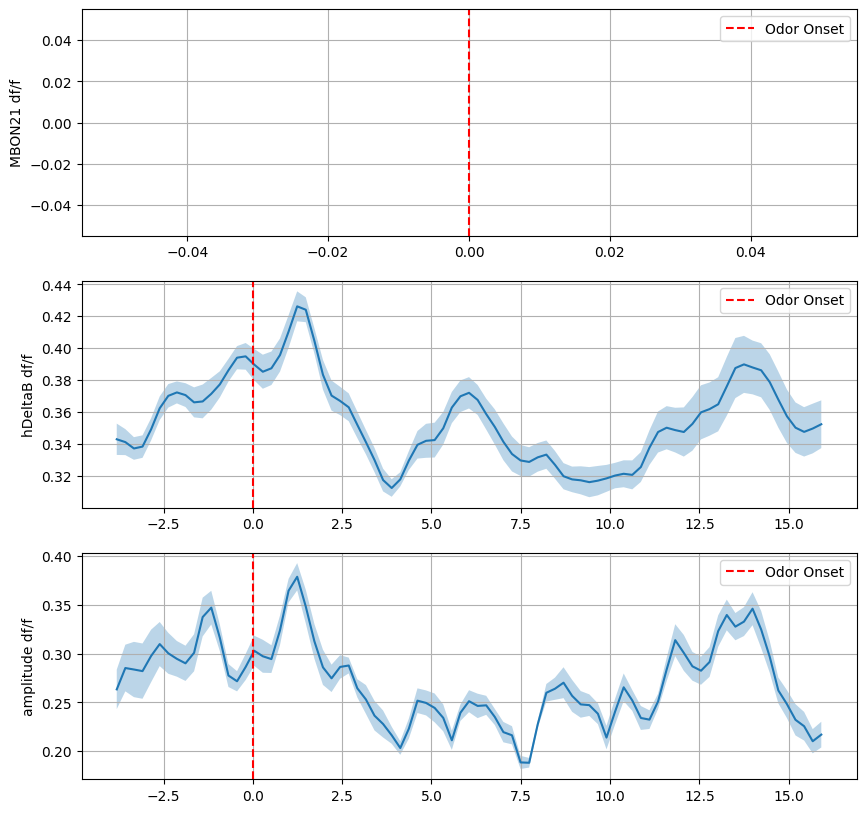

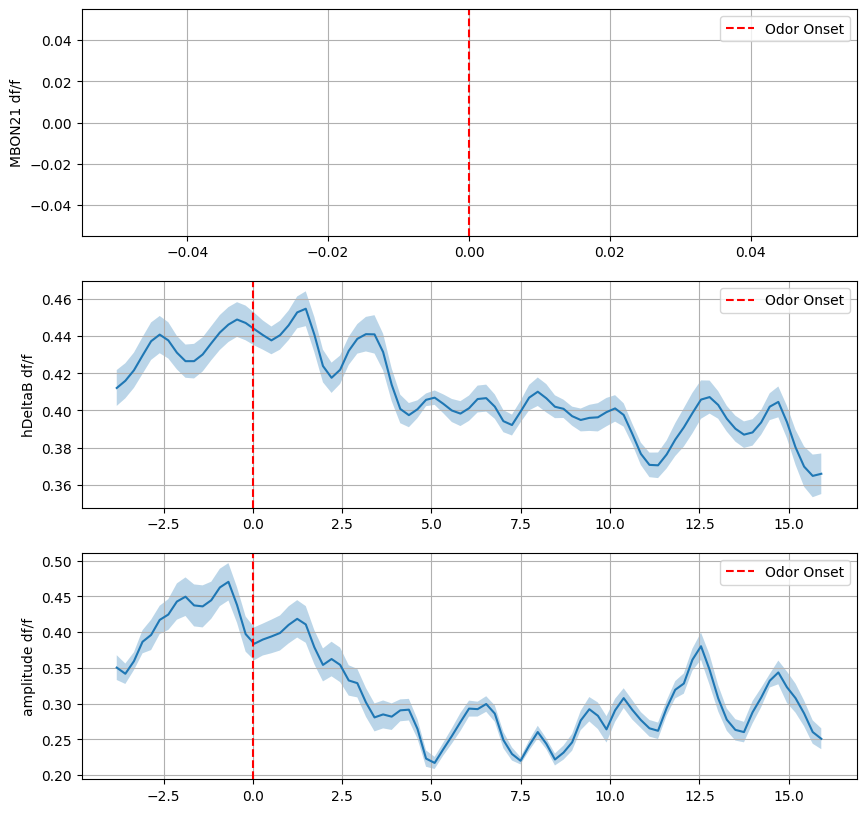

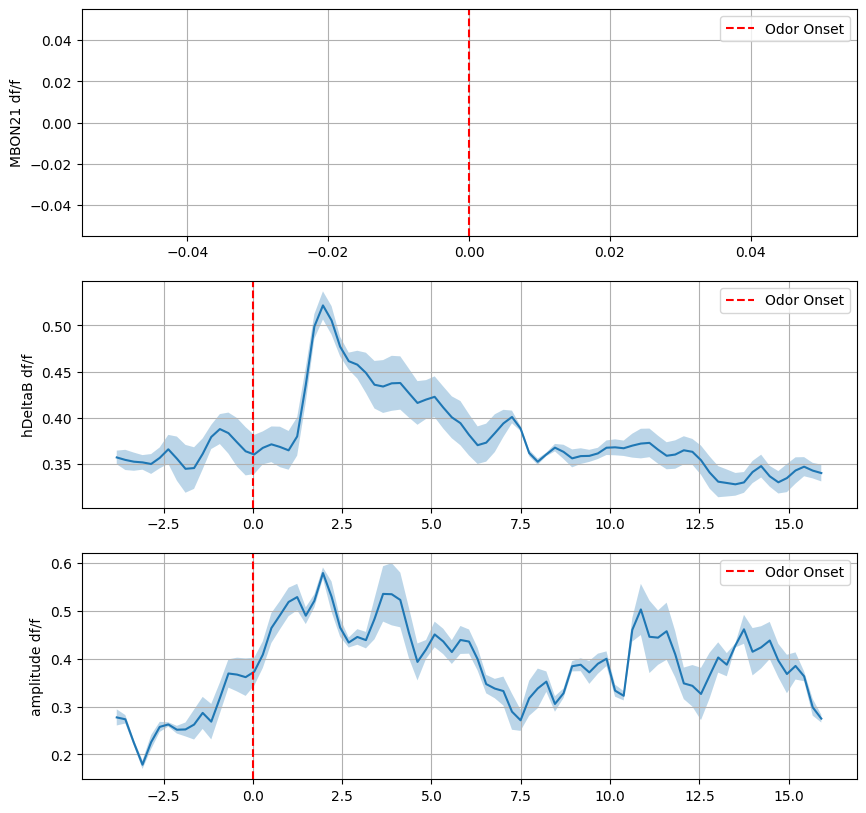

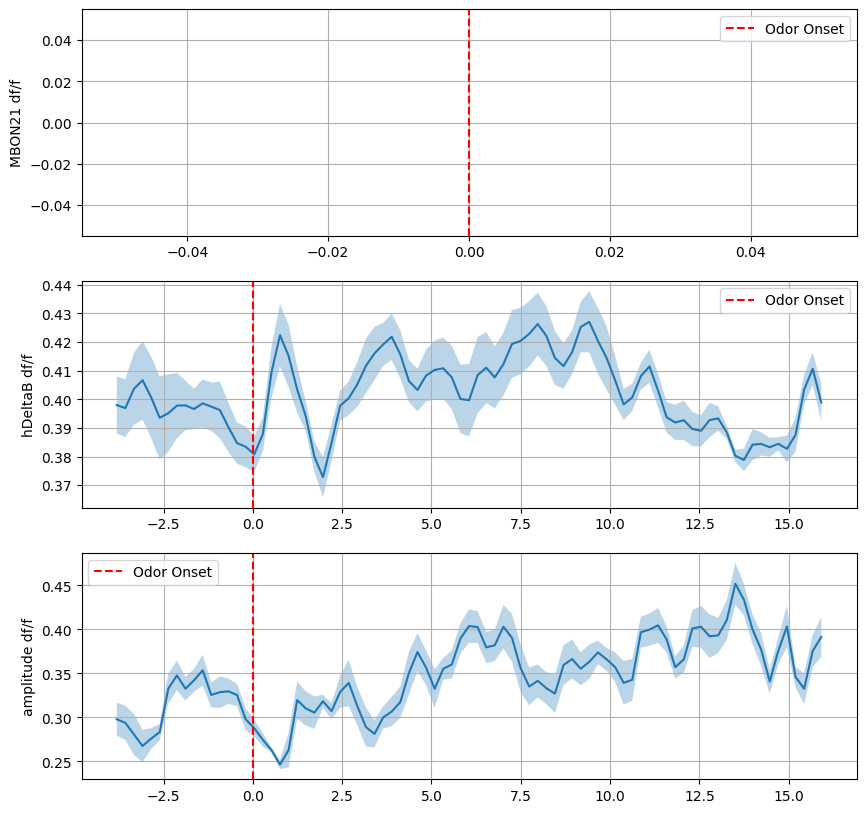

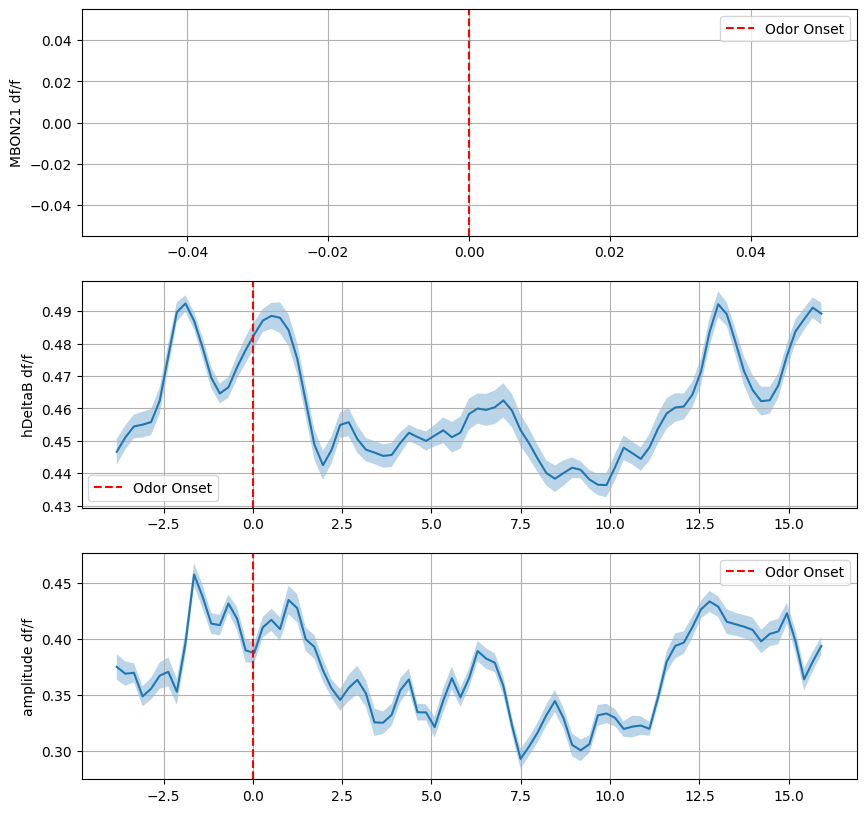

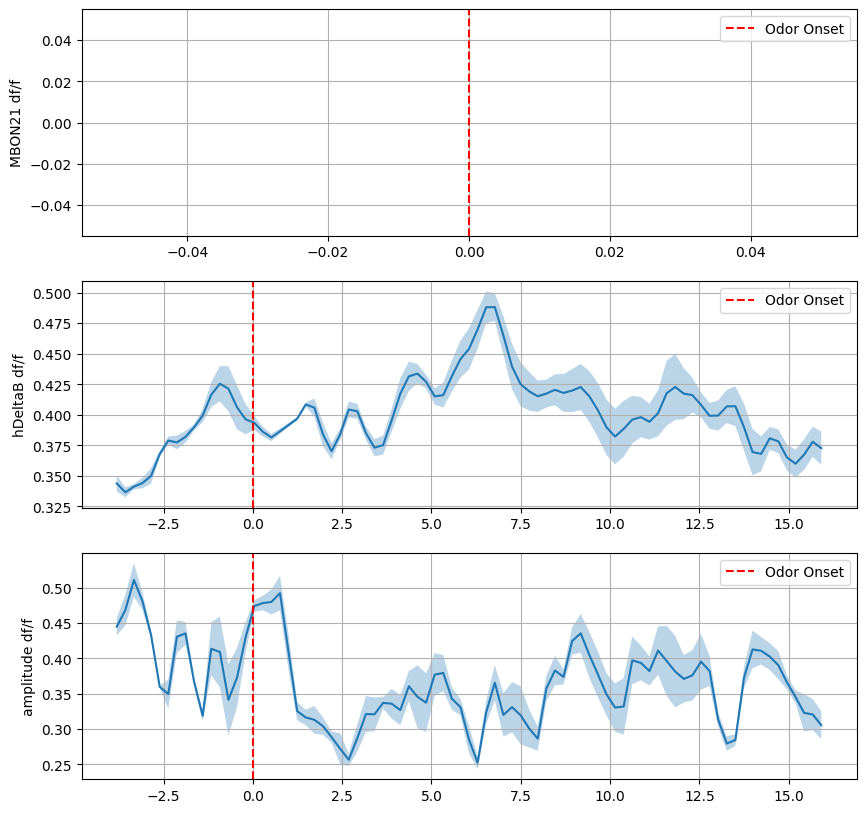

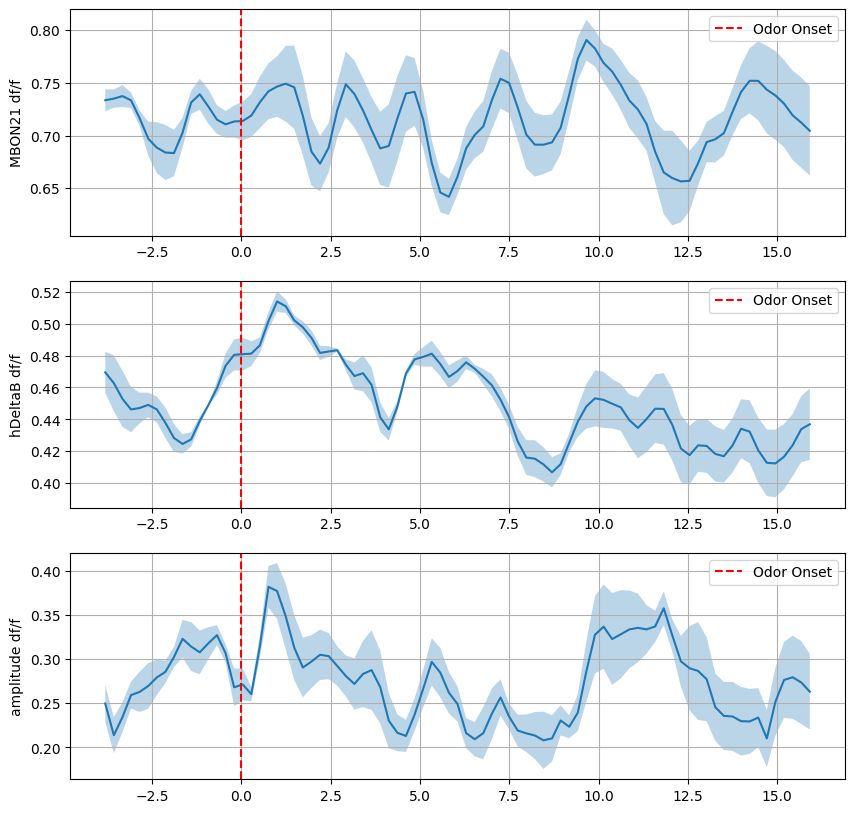

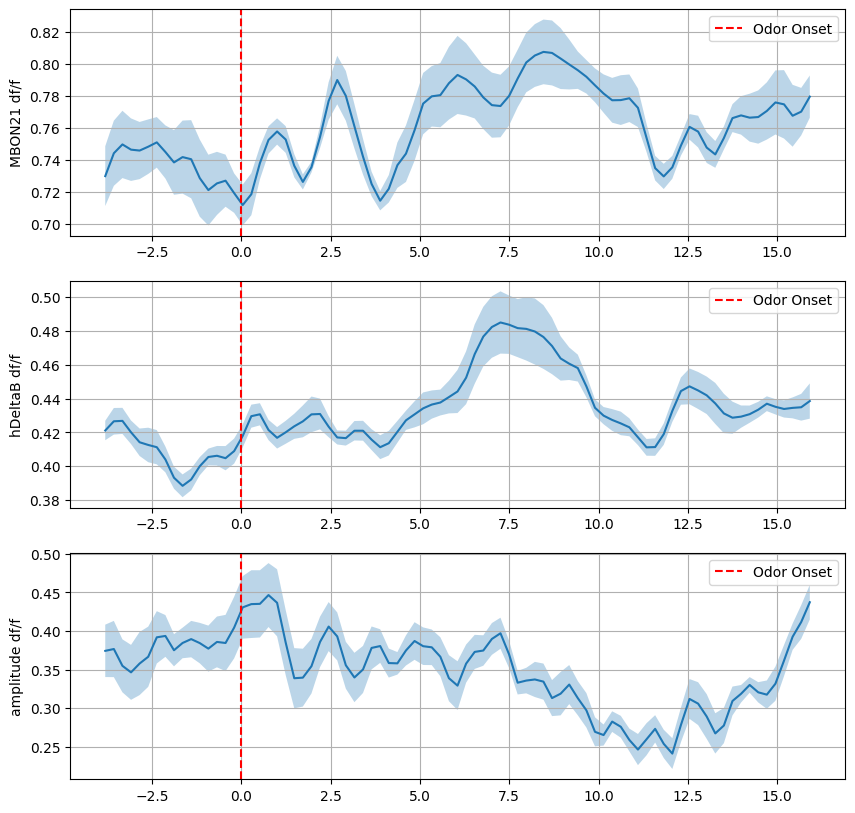

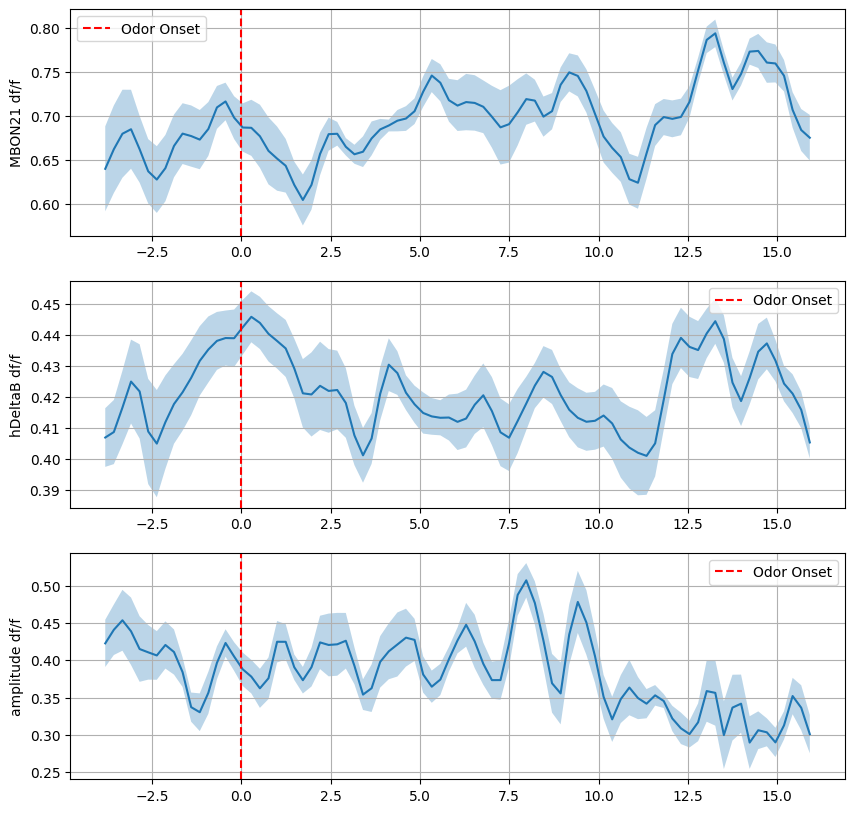

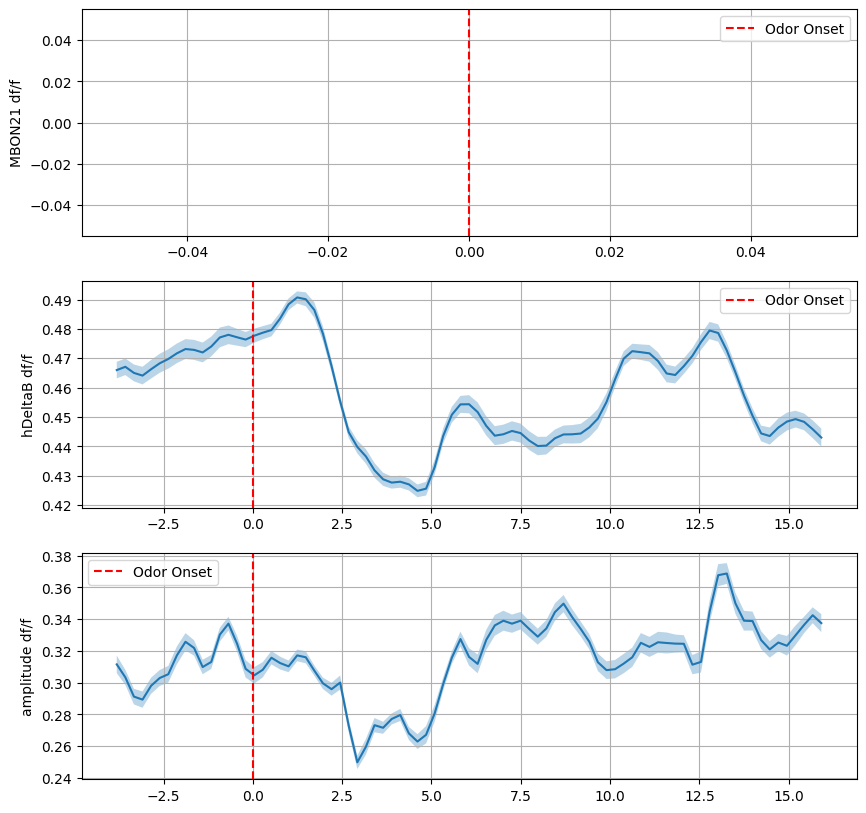

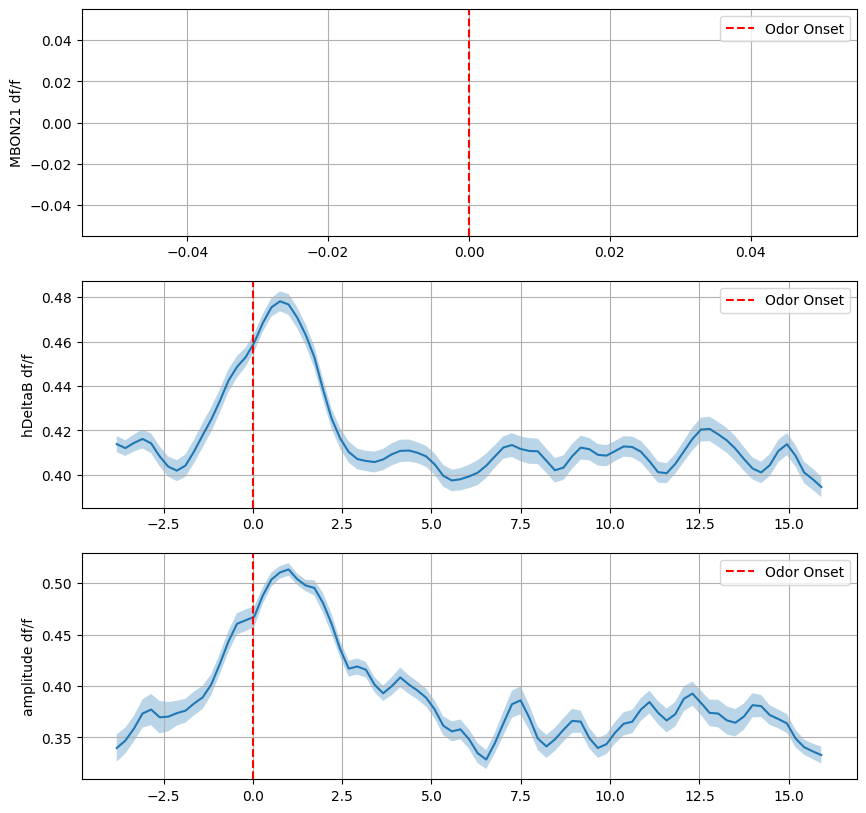

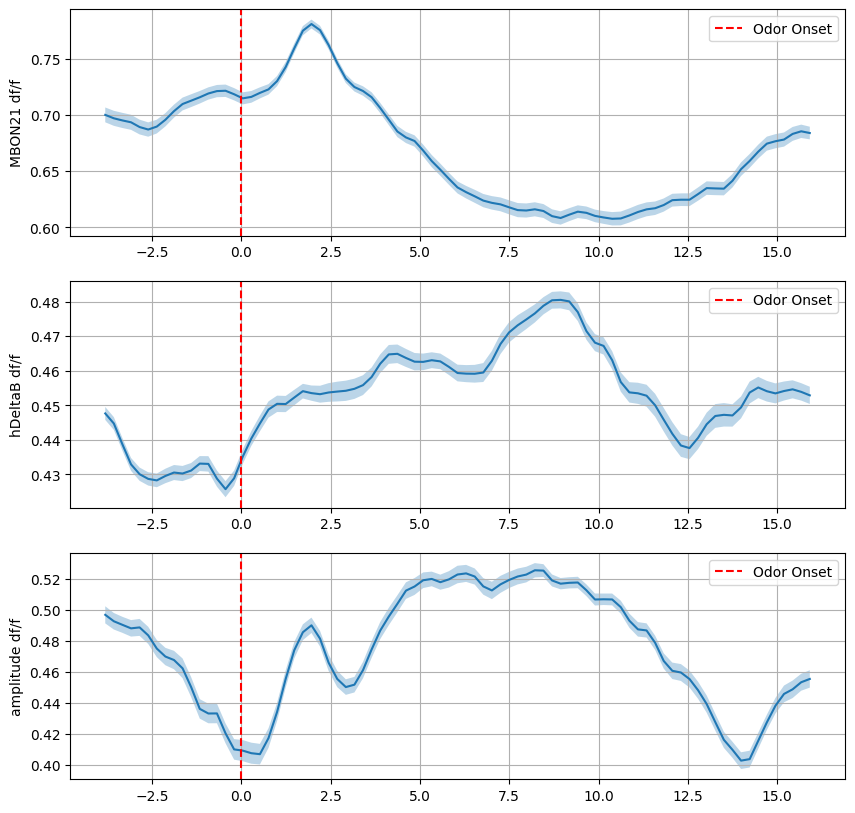

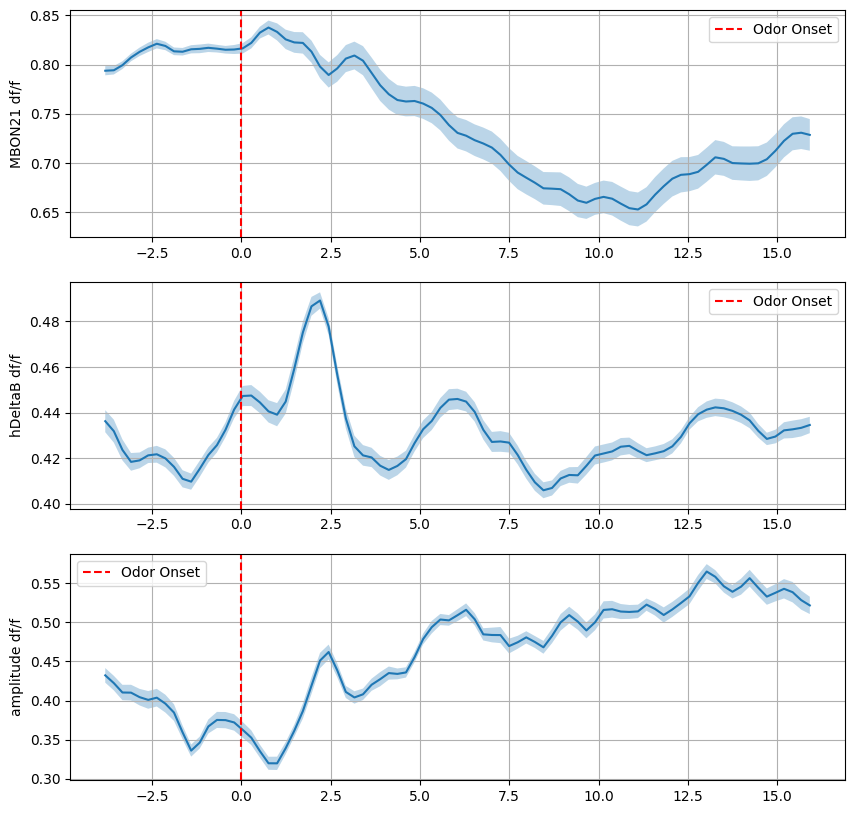

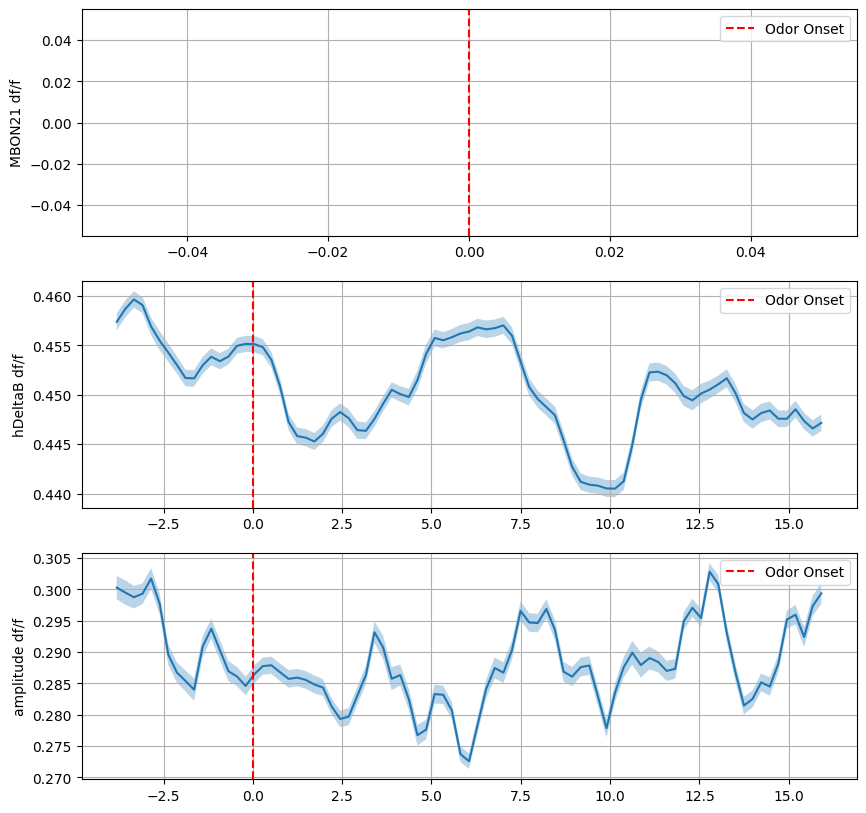

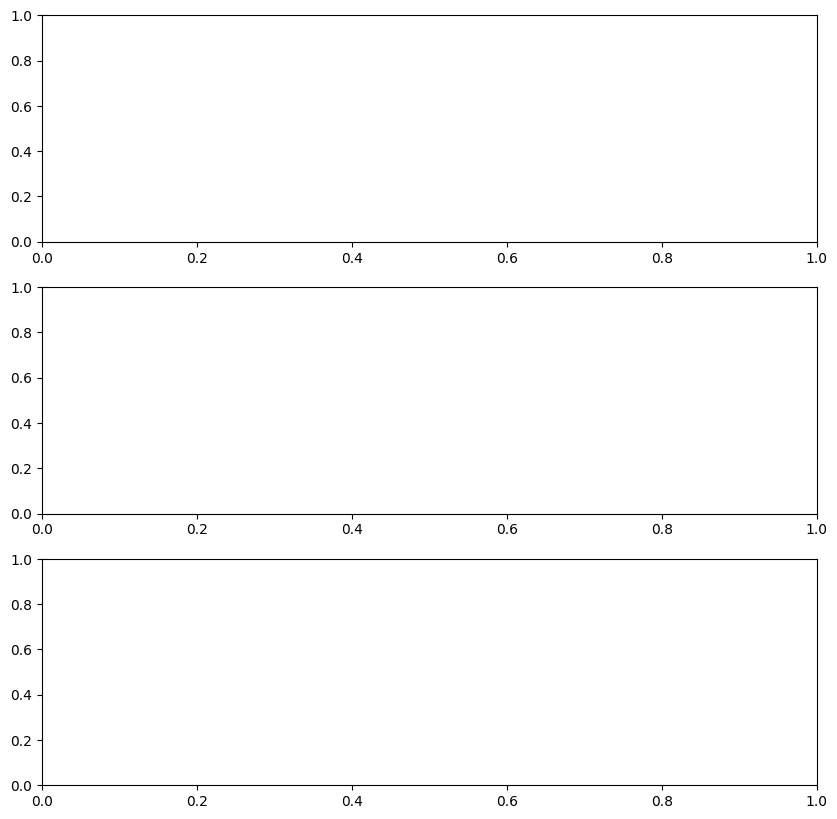

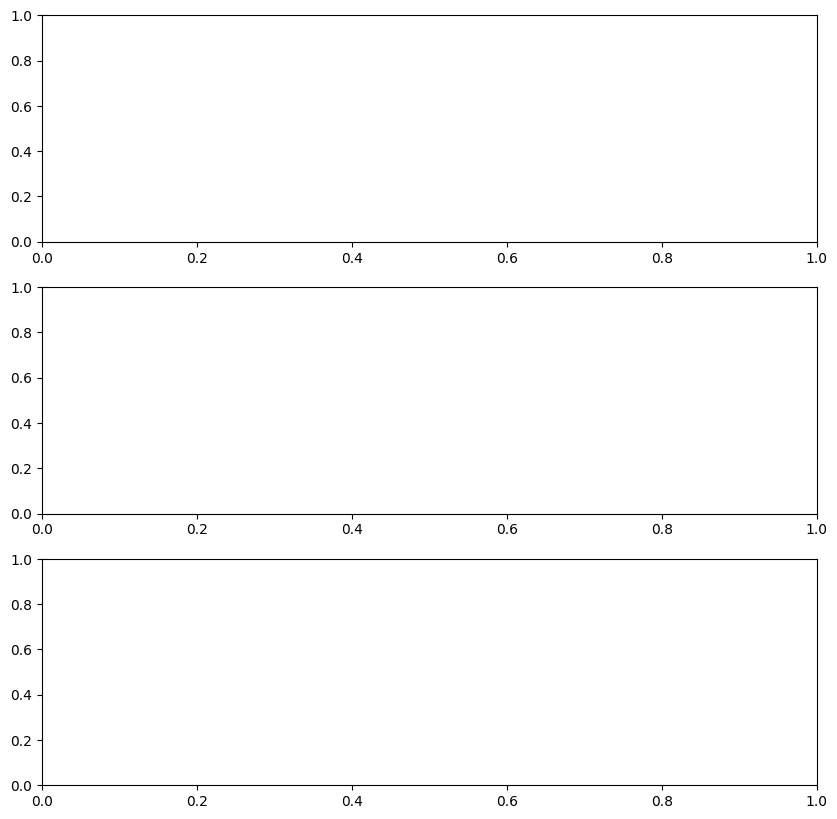

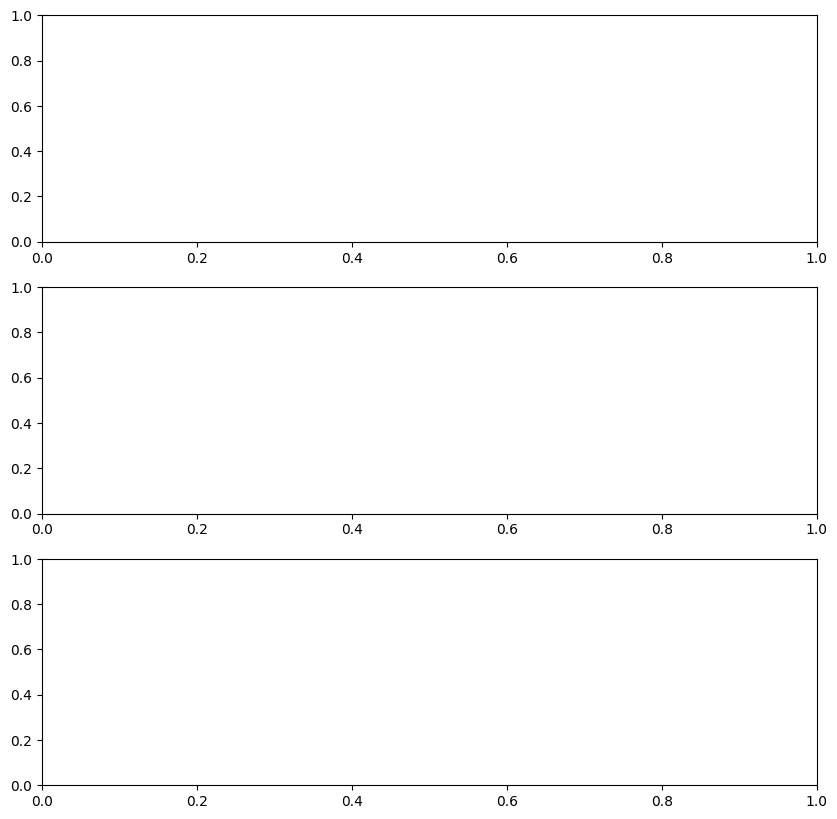

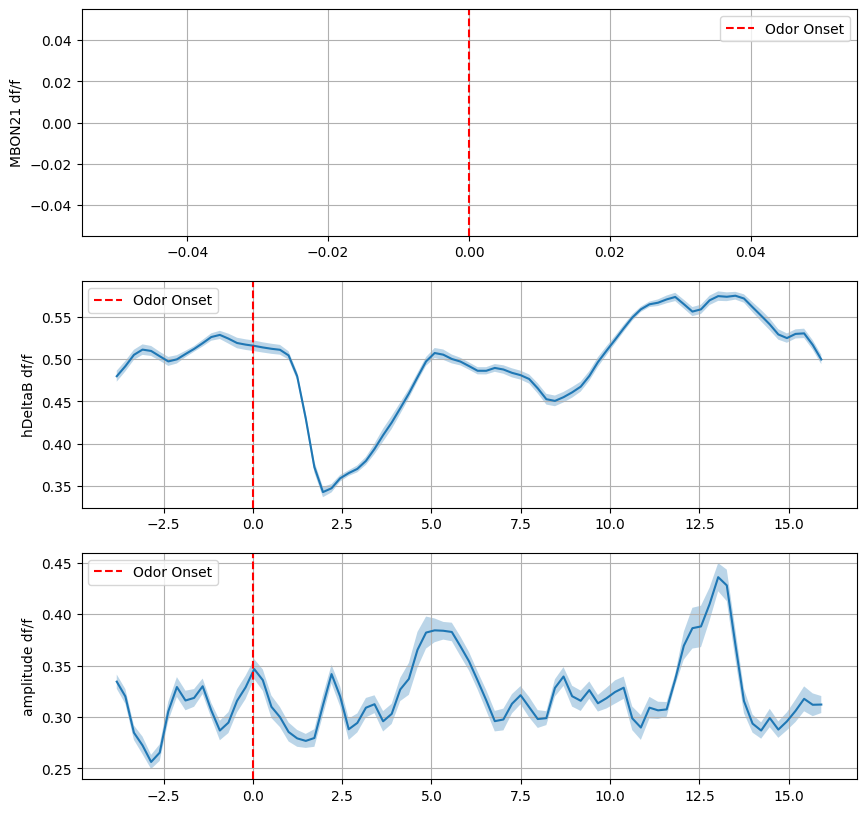

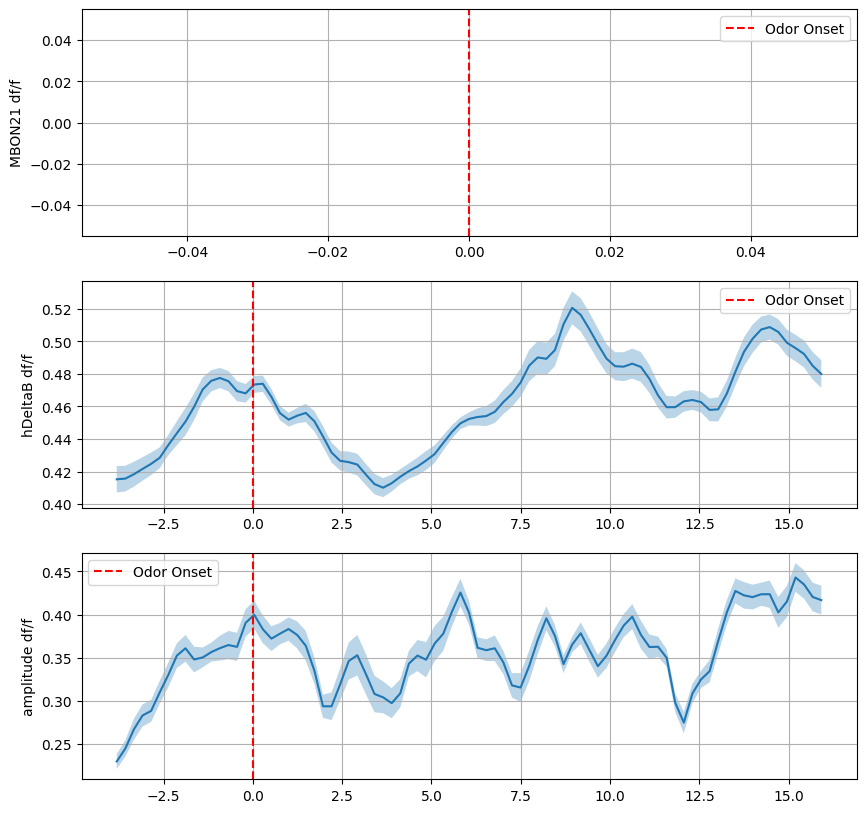

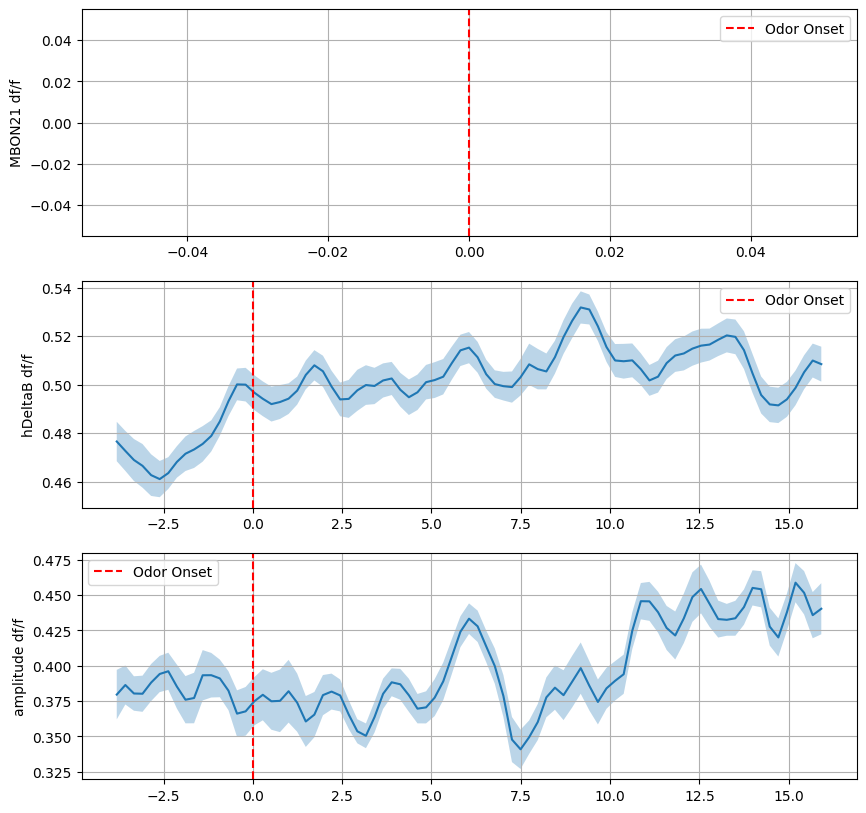

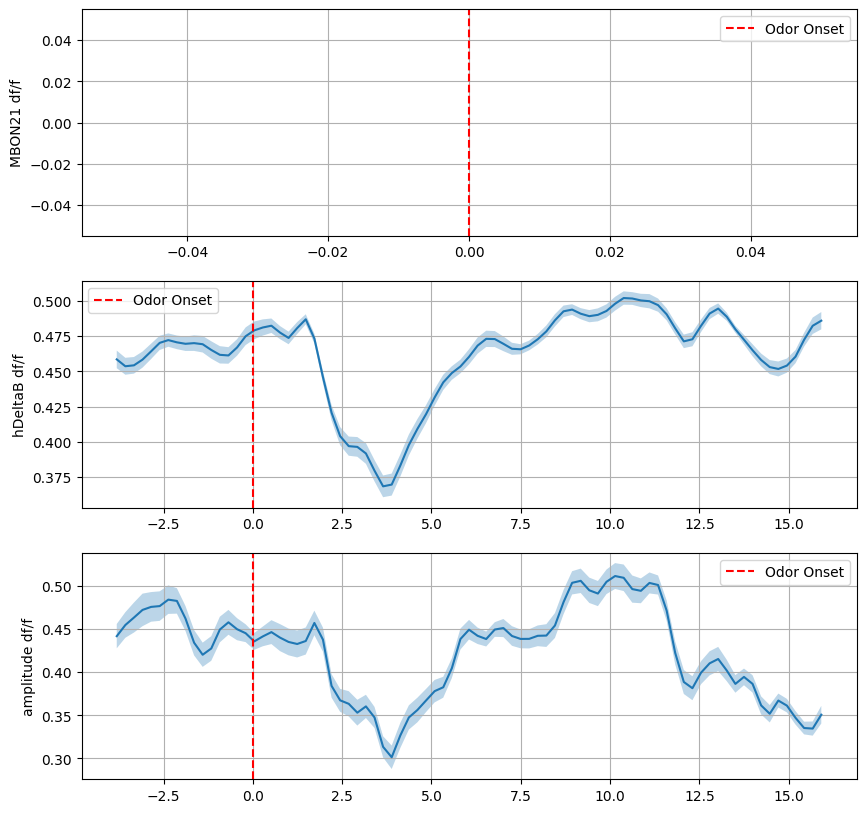

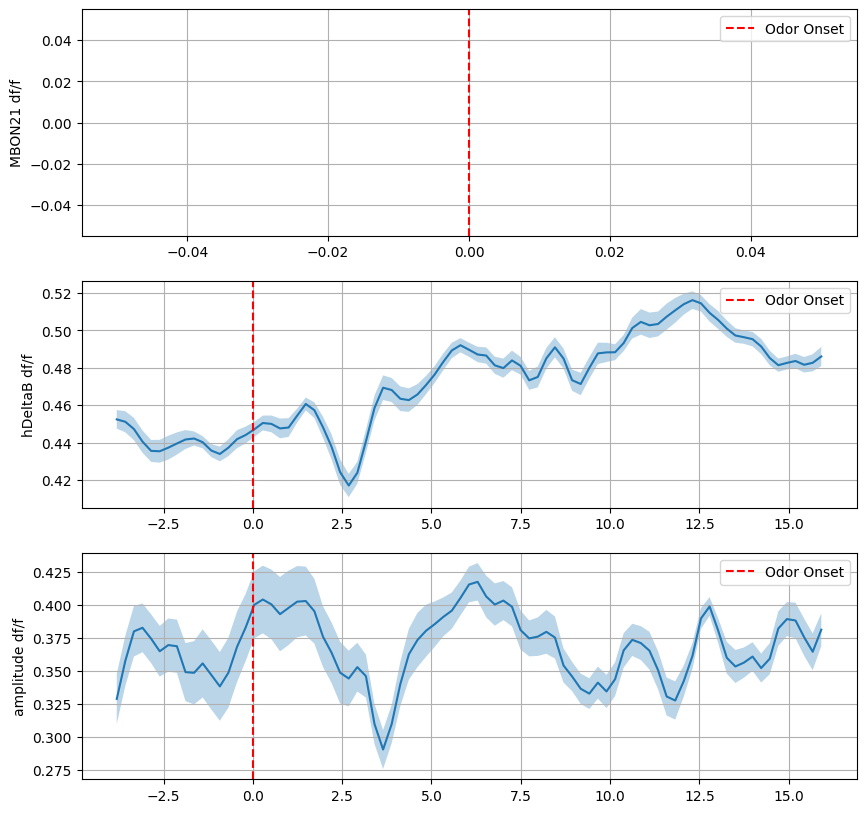

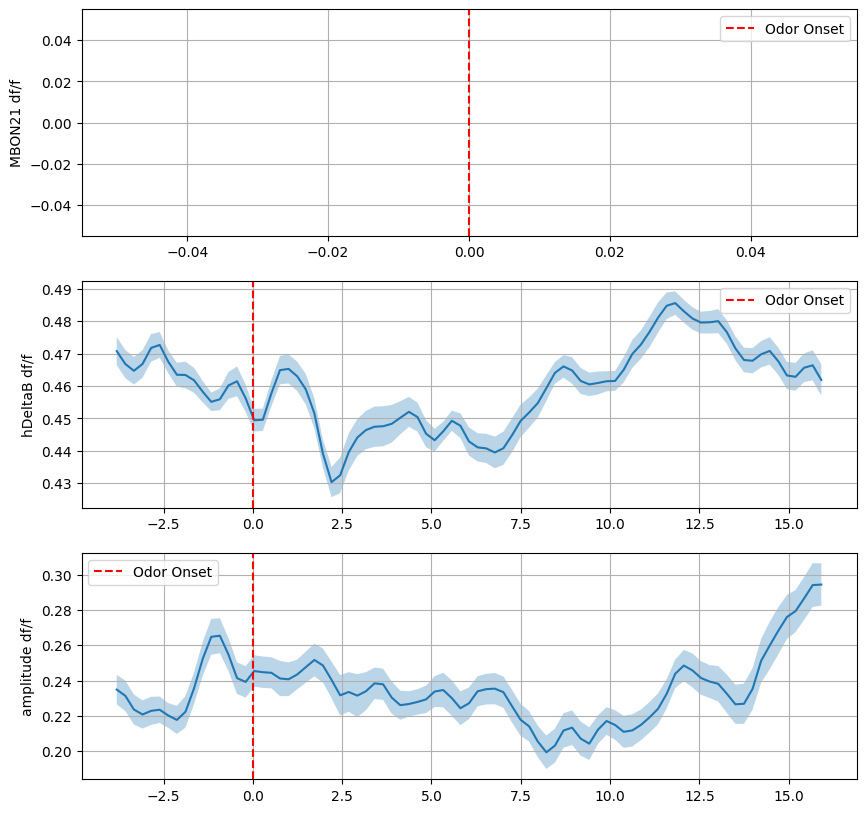

In [258]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/hDeltaB_imaging/qualified_sessions/odor_trials/"
# Path to the HDF5 file
hdf5_file_path = base_path + 'pds_all_flies.h5'

# Open the HDF5 file
with pd.HDFStore(hdf5_file_path, 'r') as store:
    # Loop through each key in the HDF5 file
    for key in store.keys():
        print(f"Processing {key}...")
        
        # Read the DataFrame associated with the current key
        df = store[key]
        if 'odor' in df.columns and np.mean(df.odor[0:100]) < 1:
        # Perform operations on the DataFrame
        #print(df.head())  # Display the first few rows of the DataFrame
        
        # Example of more complex operations you might want to perform
        # For example, calculating the mean of a column if it exists
            fig, ax = plt.subplots(3,1,figsize=(10,10))
            kws = ['MBON21','hDeltaB','amplitude']
            for i in range(len(ax)):
                plot_average_odor_response(df,kws[i],ax=ax[i],minmax_norm=True)
            #plt.close()
        # Or, simply display some information about the DataFrame
        #print(f"Statistics for {key}:")
        #print(df.describe())  # Summary statistics for the DataFrame
        else:
            continue

In [ ]:
# plot around odor delivery
def find_odor_start_end(behav_df):
    odor_on = behav_df[behav_df.odor > 5].index
    odor_start = [odor_on[0]]
    odor_end = []
    for i in range(len(odor_on)-1):
        if odor_on[i+1] - odor_on[i]>5:
            odor_start.append(odor_on[i+1])
            odor_end.append(odor_on[i])
    if odor_on[-1] != len(behav_df)-1:
        odor_end.append(odor_on[-1])
    return odor_start[0:len(odor_end)], odor_end
odor_start, odor_end = find_odor_start_end(behav_df)


In [ ]:
roi_kw = 'hDeltaB'
roi_mtx = imaging_behavior_functions.extract_heatmap(neural_df, roi_kw, 1, example_path_results, trial_num)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))
param_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
param_df

In [20]:

def tuning_curve_1d(behavior_variable, neural_activity, neurons_to_plot, num_bins, ax=None):
    """
    Plot tuning curves on the given matplotlib Axes.

    Parameters:
    - behavior_variable: array-like, the behavioral variable to bin.
    - neural_activity: 2D array-like, neural activity data with shape (neurons, observations).
    - neurons_to_plot: list of int, indices of neurons to plot.
    - num_bins: int, number of bins to divide the behavior variable into.
    - ax: matplotlib.axes.Axes, the axes object to plot on. If None, a new figure is created.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Bin the behavioral variable
    bins = np.linspace(np.min(behavior_variable), np.max(behavior_variable), num_bins+1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Plot tuning curves with SEM for selected neurons
    for neuron_index in neurons_to_plot:
        binned_activity = np.empty(num_bins)
        binned_sem = np.empty(num_bins)
        
        for i in range(num_bins):
            indices = np.where((behavior_variable >= bins[i]) & (behavior_variable < bins[i+1]))[0]
            bin_data = neural_activity[neuron_index, indices]
            binned_activity[i] = np.mean(bin_data)
            binned_sem[i] = sem(bin_data)

        ax.plot(bin_centers, binned_activity, label=f'Neuron {neuron_index}')
        ax.fill_between(bin_centers, binned_activity - binned_sem, binned_activity + binned_sem, alpha=0.3)

    # Setting labels and title
    ax.set_xlabel('Behavioral Variable')
    ax.set_ylabel('Average Neural Activity')
    ax.legend()
    ax.set_title('Neural Activity Tuning Curves with SEM')

# Example usage:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# for i, ax in enumerate(axs):
#     tuning_curve_1d(behavior_variable, neural_activity, [i], 10, ax=ax)
# plt.show()



def filter_based_on_histogram(behavior_variable, min_freq_threshold):
    """
    Filters the behavioral variable data to remove points distant from the main mode,
    isolated by at least two consecutive bins with very low frequency. Automatically adjusts
    bins based on the Freedman-Diaconis rule.
    
    Parameters:
    - behavior_variable: Pandas Series, the behavioral variable data.
    - min_freq_threshold: The minimum frequency (as a proportion of total) to consider a bin as non-negligible.
    
    Returns:
    - Pandas Series, filtered behavioral variable data.
    """
    # Calculate bin width using the Freedman-Diaconis rule
    #IQR = np.subtract(*np.percentile(behavior_variable, [75, 25]))
    #n = len(behavior_variable)
    bin_width = 1
    range_ = np.max(behavior_variable) - np.min(behavior_variable)
    bins = int(np.round(range_ / bin_width))
    print(bins)
    # Compute the histogram with the calculated number of bins
    counts, bin_edges = np.histogram(behavior_variable, bins=bins)
    #total_points = n
    #freqs = counts / total_points  # Frequency of each bin
    
    # Identify bins below the frequency threshold
    low_freq_bins_mask = counts < min_freq_threshold
    
    # Find indices where two consecutive bins are below the threshold
    two_consecutive_low_bins = np.where(np.convolve(low_freq_bins_mask, [1,1], mode='valid') == 2)[0]
    
    if two_consecutive_low_bins.size == 0:
        return behavior_variable  # No such consecutive low bins, return original series
    
    # Determine cutoffs
    mode_bin_index = np.argmax(counts)
    lower_cutoff_bins = two_consecutive_low_bins[two_consecutive_low_bins < mode_bin_index]
    upper_cutoff_bins = two_consecutive_low_bins[two_consecutive_low_bins > mode_bin_index]
    lower_cutoff = bin_edges[0] if lower_cutoff_bins.size == 0 else bin_edges[lower_cutoff_bins.max() + 2]  # +2 to include the low bin
    upper_cutoff = bin_edges[-1] if upper_cutoff_bins.size == 0 else bin_edges[upper_cutoff_bins.min()]
    
    # Filter the behavioral variable
    filtered_variable = behavior_variable[(behavior_variable >= lower_cutoff) & (behavior_variable <= upper_cutoff)]
    
    return filtered_variable
# Example usage:
#tuning_curve_1d(behavior_variable, neural_activity,neurons_to_plot,num_bins)

21
233
52
6


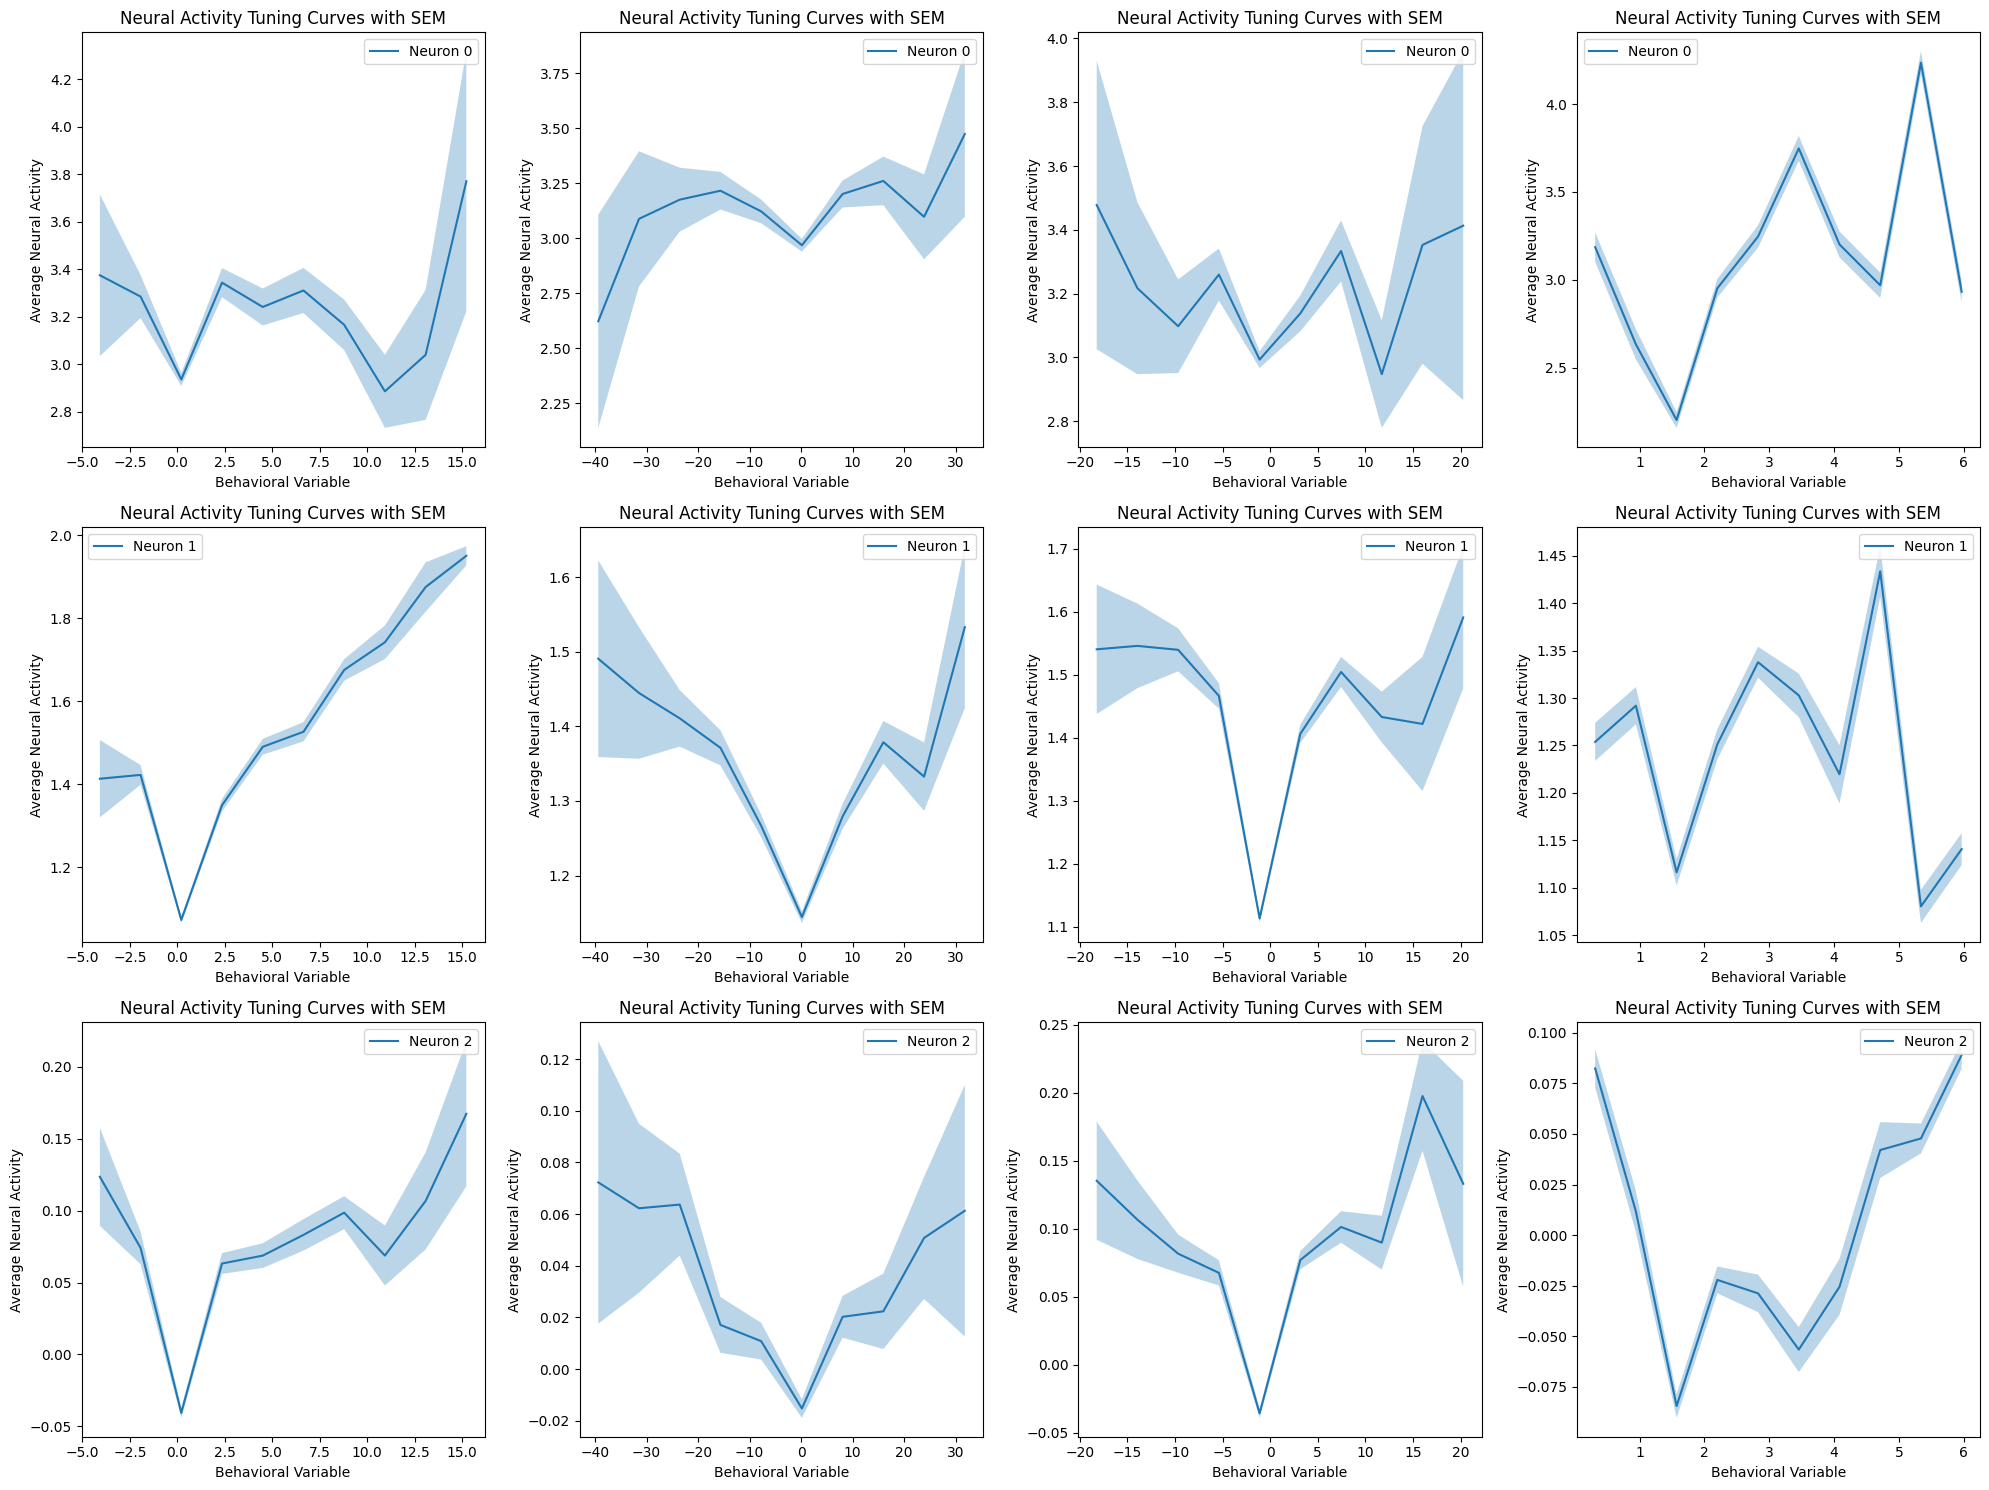

In [27]:
# Determine the number of rows and columns for the subplot grid
behavioral_variables = [behav_df.fwV, behav_df.sideV, behav_df.yawV, behav_df.heading]
filtered_behavior_variables = [filter_based_on_histogram(var, 0.5) for var in behavioral_variables]
num_bins = 10
neurons_to_plot = [0,1,2]
neural_activity = np.array(param_df[['phase','amplitude','baseline']].T)
num_behavioral_variables = len(filtered_behavior_variables)
fig, ax = plt.subplots(3,4,figsize=(20,15))
for j in neurons_to_plot:
    for i, behavior_variable in enumerate(filtered_behavior_variables):
        tuning_curve_1d(behavior_variable, neural_activity,[j],num_bins,ax=ax[j,i])
plt.tight_layout()
# Loop through behavioral variables and plot
#for i, behavior_variable in enumerate(filtered_behavior_variables):
    #tuning_curve_pop(num_bins, behavior_variable, neural_activity)


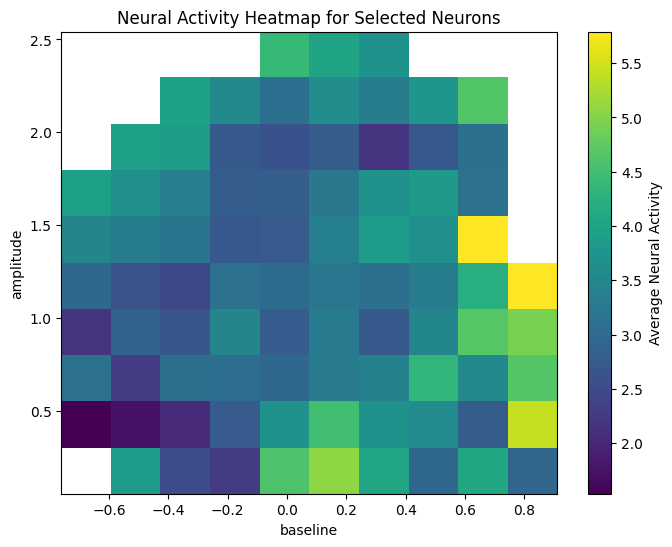

In [19]:
def tuning_curve_2d(behavior_variable_1, behavior_variable_2, neural_activity,neuron_index,num_bins_1,num_bins_2):
# Create bins for both behavioral variables
    bins_1 = np.linspace(np.min(behavior_variable_1), np.max(behavior_variable_1), num_bins_1 + 1)
    bins_2 = np.linspace(np.min(behavior_variable_2), np.max(behavior_variable_2), num_bins_2 + 1)

    # Initialize an array to hold the mean activity for each bin combination
    mean_activity_matrix = np.zeros((num_bins_1, num_bins_2))

    # Calculate the mean activity for each bin combination
    for i in range(num_bins_1):
        for j in range(num_bins_2):
            # Find indices that fall into the current bin combination
            indices = np.where((behavior_variable_1 >= bins_1[i]) & (behavior_variable_1 < bins_1[i+1]) &
                            (behavior_variable_2 >= bins_2[j]) & (behavior_variable_2 < bins_2[j+1]))[0]
            # Calculate mean activity for these indices
            if len(indices) > 0:
                #print(indices)
                mean_activity_matrix[i, j] = np.mean(neural_activity[:, indices][neuron_index,:])
            else:
                mean_activity_matrix[i, j] = np.nan  # Use NaN for bins with no data points

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_activity_matrix, origin='lower', aspect='auto', cmap='viridis',
            extent=[bins_2[0], bins_2[-1], bins_1[0], bins_1[-1]])
    plt.colorbar(label='Average Neural Activity')
    plt.xlabel(behavior_variable_2.name)
    plt.ylabel(behavior_variable_1.name)
    plt.title(f'Neural Activity Heatmap for Selected Neurons')
    plt.show()
neural_activity = np.array(behav_df[['heading']].T)
tuning_curve_2d(param_df.amplitude, param_df.baseline,neural_activity,0,10,10)

## PCA

In [59]:
def perform_pca(selected_df, n_components=3):
    """
    Perform PCA on the given dataframe.

    Args:
    - data (pd.DataFrame): The dataframe containing neuron activity data.
    - n_components (int): The number of principal components to compute.

    Returns:
    - pca (PCA object): The PCA object after fitting the data.
    - transformed_data (np.array): Data transformed into principal components.
    - explained_variance_ratio (np.array): The amount of variance explained by each of the selected components.
    """
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(selected_df)

    # Perform PCA
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(scaled_data)
    explained_variance_ratio = pca.explained_variance_ratio_

    return pca, transformed_data, explained_variance_ratio
pca, transformed_data, explained_variance_ratio = perform_pca(selected_df,n_components=3)

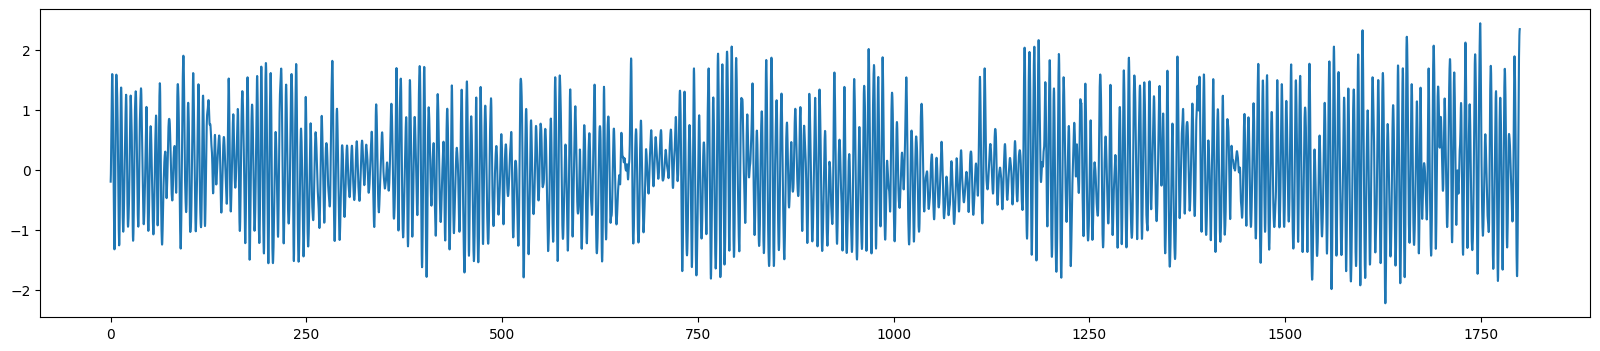

In [103]:
def dynamic_func(x, baseline, amp, phase):
    return baseline+amp * np.cos(x + phase)
phasor_rep = dynamic_func(param_df.time, param_df.baseline, param_df.amplitude, param_df.phase)
fig, ax = plt.subplots(figsize = (20,4))
ax.plot(param_df.time, gaussian_filter1d(phasor_rep, sigma=2))
#ax2 = ax.twinx()
#ax2.plot(param_df.time, param_df.baseline,'r', alpha=0.5)

## Delayed time embedding

In [62]:


def time_delay_embedding(signal, delay, dimension):
    """
    Perform time-delay embedding on a given signal.
    
    Parameters:
    - signal: The input signal (time series) as a numpy array.
    - delay: The delay time for embedding.
    - dimension: The embedding dimension.
    
    Returns:
    - Embedded signal as a 2D numpy array.
    """
    emb_length = len(signal) - (dimension - 1) * delay
    embedded_signal = np.empty((emb_length, dimension))
    for i in range(dimension):
        embedded_signal[:, i] = signal[i * delay:i * delay + emb_length]
    return embedded_signal

signal = phasor_rep

# Set the parameters for the time-delay embedding
delay = 6  # The delay in time steps
dimension = 3  # The dimensionality of the latent space

# Perform the time-delay embedding
embedded_signal = time_delay_embedding(signal, delay, dimension)
U, Sigma, VT = np.linalg.svd(embedded_signal.T, full_matrices=False)



In [63]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(MLP, self).__init__()
        # Define the first layer (input to hidden)
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        # Define the second layer (hidden to output)
        self.output = nn.Linear(hidden_size2, 1)
    
    def forward(self, x):
        # Forward pass through the hidden layer with ReLU activation
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        # Forward pass through the output layer
        x = self.output(x)
        return x

In [99]:
# TODO modify
#X = gaussian_filter1d(phasor_rep, sigma=2)
#X = gaussian_filter1d(param_df[['baseline','amplitude','phase']].values, sigma=2)
X = param_df[['baseline','amplitude','phase']].values
X_tensor = torch.tensor(X).float()
y = imaging_behavior_functions.apply_gaussian_smoothing(behav_df.fwV, sigma=2)
#y = behav_df.fwV
y_tensor = torch.tensor(y).float()

split_train = int(len(X_tensor) * 0.6)  # 60% for training
split_val = int(len(X_tensor) * 0.8)  # 20% for validation, 20% for test

# Split the data
X_train, X_val, X_test = X_tensor[:split_train], X_tensor[split_train:split_val], X_tensor[split_val:]
y_train, y_val, y_test = y_tensor[:split_train], y_tensor[split_train:split_val], y_tensor[split_val:]

# Normalize X (Using training data mean and std)
'''mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std'''

# Assuming y_train and y_test are already tensors and do not need reshaping
y_train = y_train[:, None]  # Reshape if necessary to ensure 2D tensor for consistency
y_val = y_val[:, None]
y_test = y_test[:, None]  # Reshape if necessary
# Data loading
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [100]:
input_size = X_train.shape[1]
hidden_size1 = 2  # Example size, adjust based on performance
hidden_size2 = 2
model = MLP(input_size, hidden_size1, hidden_size2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [101]:
summary(model, input_size=(input_size, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]               8
            Linear-2                    [-1, 2]               6
            Linear-3                    [-1, 1]               3
Total params: 17
Trainable params: 17
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [102]:
epochs = 200
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            val_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}')


Epoch [10/200], Train Loss: 3.4465, Validation Loss: 3.7475
Epoch [20/200], Train Loss: 3.2139, Validation Loss: 3.3481
Epoch [30/200], Train Loss: 3.1225, Validation Loss: 3.2230
Epoch [40/200], Train Loss: 3.0764, Validation Loss: 3.1665
Epoch [50/200], Train Loss: 3.0507, Validation Loss: 3.1332
Epoch [60/200], Train Loss: 3.0351, Validation Loss: 3.1067
Epoch [70/200], Train Loss: 3.0245, Validation Loss: 3.0870
Epoch [80/200], Train Loss: 3.0166, Validation Loss: 3.0702
Epoch [90/200], Train Loss: 3.0095, Validation Loss: 3.0578
Epoch [100/200], Train Loss: 3.0034, Validation Loss: 3.0439
Epoch [110/200], Train Loss: 2.9946, Validation Loss: 3.0253
Epoch [120/200], Train Loss: 2.9864, Validation Loss: 3.0146
Epoch [130/200], Train Loss: 2.9764, Validation Loss: 3.0043
Epoch [140/200], Train Loss: 2.9668, Validation Loss: 3.0016
Epoch [150/200], Train Loss: 2.9569, Validation Loss: 3.0001
Epoch [160/200], Train Loss: 2.9469, Validation Loss: 2.9979
Epoch [170/200], Train Loss: 2.93

In [68]:
# Evaluation Loop
model.eval()  # Set model to evaluation mode
predictions = []  # List to store predictions for each batch
train_predictions = []

total_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_test = model(X_batch)
        predictions.append(y_pred_test)
        total_loss += loss_function(y_pred_test, y_batch).item()
y_pred_test = torch.cat(predictions, dim=0)
average_loss = total_loss / len(test_loader)
print(f'Average Test Loss: {average_loss:.4f}')

total_train_loss = 0
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        y_pred_train = model(X_batch)
        train_predictions.append(y_pred_train)
        total_train_loss += loss_function(y_pred_train, y_batch).item()
y_pred_train = torch.cat(train_predictions, dim=0)
average_loss = total_train_loss / len(train_loader)
print(f'Average Train Loss: {average_loss:.4f}')


Average Test Loss: 4.4836
Average Train Loss: 2.9007


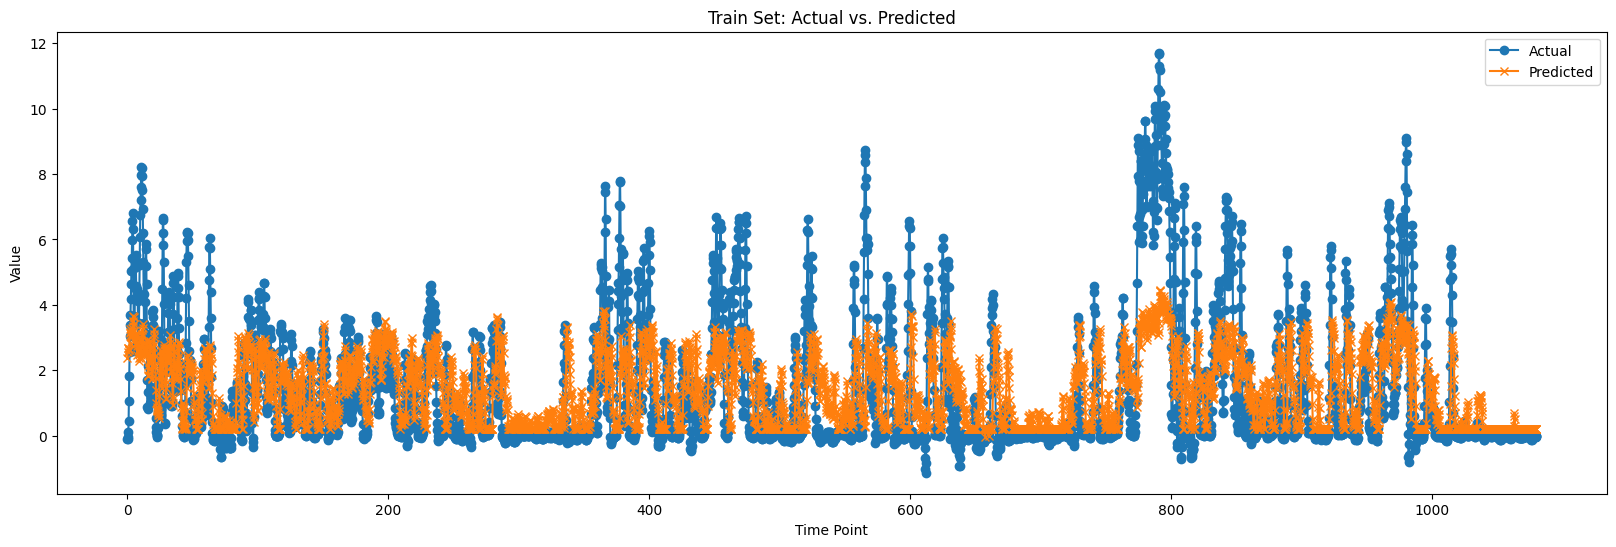

In [89]:
y_pred_train_np = y_pred_train.squeeze().numpy()
y_train_np = y_train.squeeze().numpy()

# Assuming sequential time points for the test set
time_points = behav_df.time[:split_train]

plt.figure(figsize=(20, 6))
plt.plot(time_points, y_train_np, label='Actual', marker='o')
plt.plot(time_points, y_pred_train_np, label='Predicted', marker='x')
plt.title('Train Set: Actual vs. Predicted')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.show()

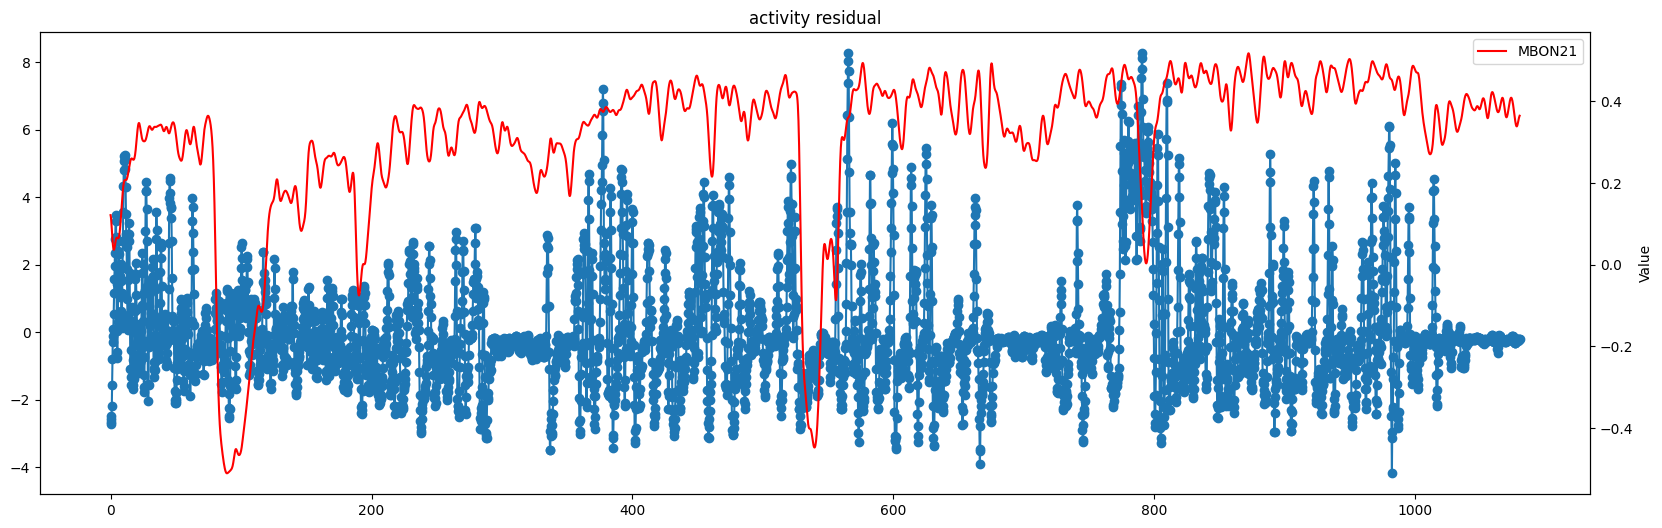

In [94]:
train_residual = y_train_np - y_pred_train_np
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(time_points, train_residual, label='Residual', marker='o')
ax2 = ax.twinx()
ax2.plot(neural_df.time[:split_train], neural_df.smoothed_MBON21[:split_train], label='MBON21',color='red')
plt.title('activity residual')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.show()

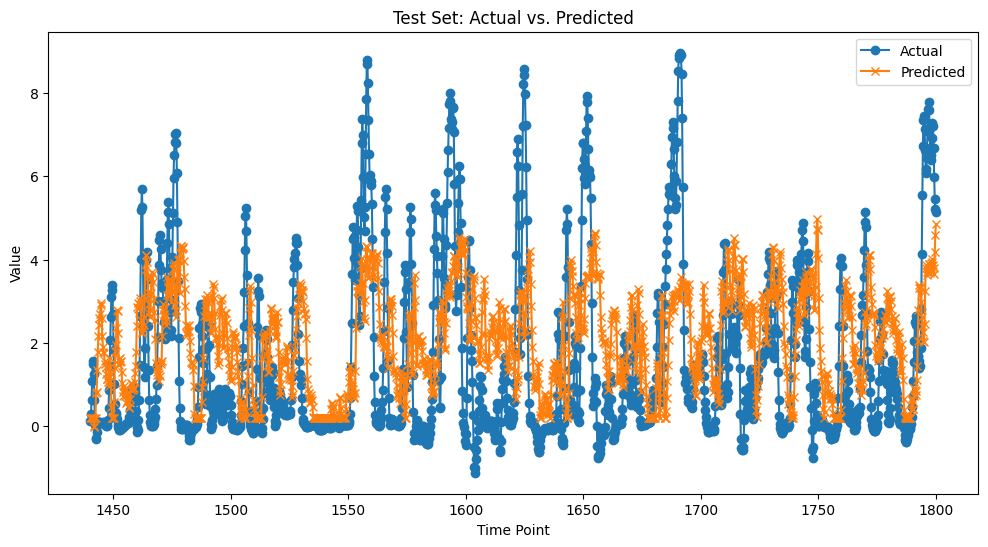

In [70]:
y_pred_test_np = y_pred_test.squeeze().numpy()
y_test_np = y_test.squeeze().numpy()

# Assuming sequential time points for the test set
time_points = behav_df.time[split_val:]

plt.figure(figsize=(12, 6))
plt.plot(time_points, y_test_np, label='Actual', marker='o')
plt.plot(time_points, y_pred_test_np, label='Predicted', marker='x')
plt.title('Test Set: Actual vs. Predicted')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.show()


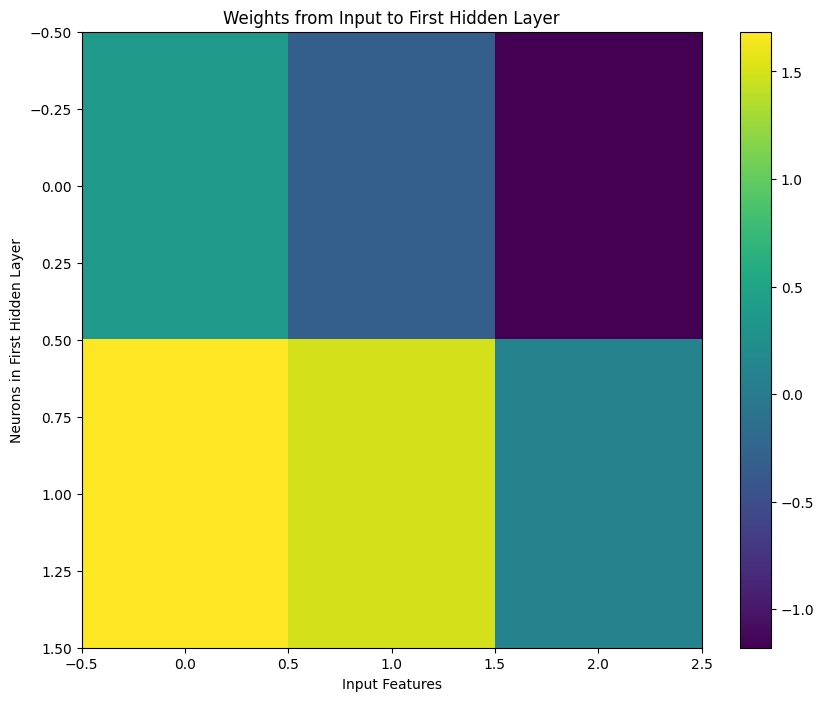

In [71]:
# Extract weights
weights_fc1 = model.hidden1.weight.data.numpy()

# Visualize weights as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(weights_fc1, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Input Features')
plt.ylabel('Neurons in First Hidden Layer')
plt.title('Weights from Input to First Hidden Layer')
plt.show()


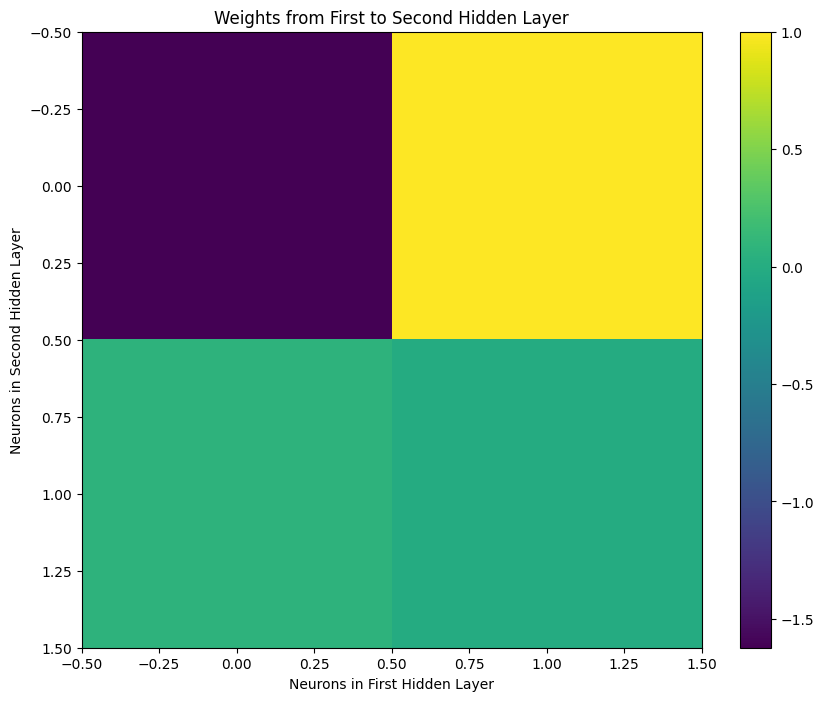

In [72]:
# Extract weights
weights_fc2 = model.hidden2.weight.data.numpy()

# Visualize weights as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(weights_fc2, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Neurons in First Hidden Layer')
plt.ylabel('Neurons in Second Hidden Layer')
plt.title('Weights from First to Second Hidden Layer')
plt.show()


In [73]:
nn_pd = pd.DataFrame()
nn_pd['num_hidden'] = 2
nn_pd['num_per_hidden'] = 5
nn_pd['num_epoch'] = 100
nn_pd['train_loss'] = 2.8474
nn_pd['test_loss'] = 4.8161


## RNN modeling

In [75]:
radius = imaging_behavior_functions.apply_gaussian_smoothing(param_df.amplitude,5)
phase = imaging_behavior_functions.apply_gaussian_smoothing(param_df.phase,5)
time = param_df.time

# Create a polar plot
fig = go.Figure(data=go.Scatterpolar(
    r = radius,
    theta = np.degrees(phase),  # Convert phase from radians to degrees for plotting
    mode = 'markers',  # Display both markers and lines
    marker=dict(size=5, color=time, colorscale='Viridis')
))

# Customize layout
fig.update_layout(
    title='Evolution of Phase-Radius Combination Over Time',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, np.max(radius)]  # Adjust the range if necessary
        ),
    ),
    showlegend=False
)

# Show the plot
fig.show()


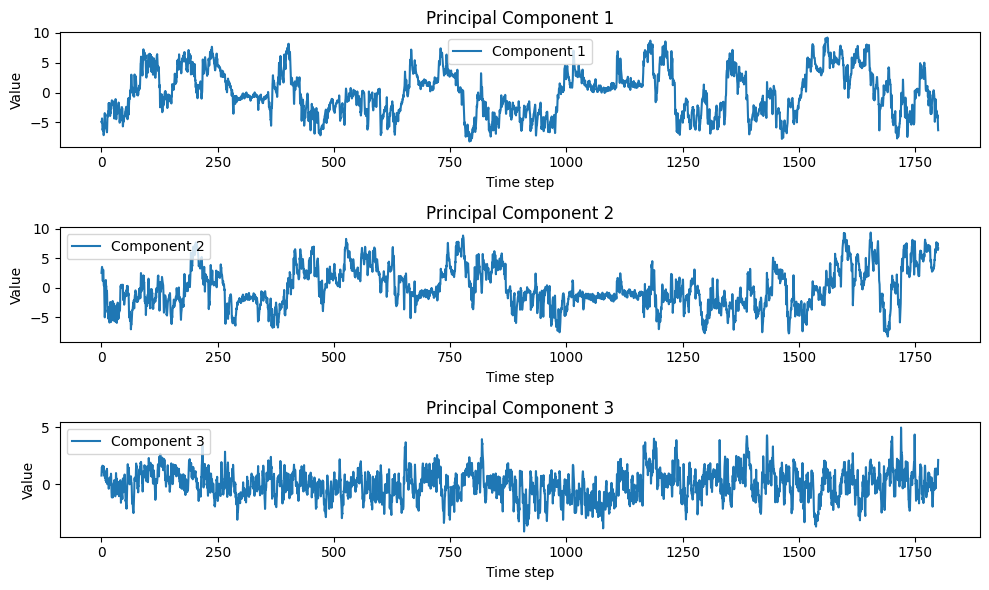

In [76]:
# visualze top PCstime_steps = range(transformed_data.shape[0])

n_components = 3
time_steps = range(transformed_data.shape[0])

# Create a figure with subplots
fig, axes = plt.subplots(n_components, 1, figsize=(10, 2*n_components))

for i in range(n_components):
    ax = axes[i]
    ax.plot(neural_df.time, transformed_data[:, i], label=f'Component {i+1}')
    ax.set_title(f'Principal Component {i+1}')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Value')
    ax.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

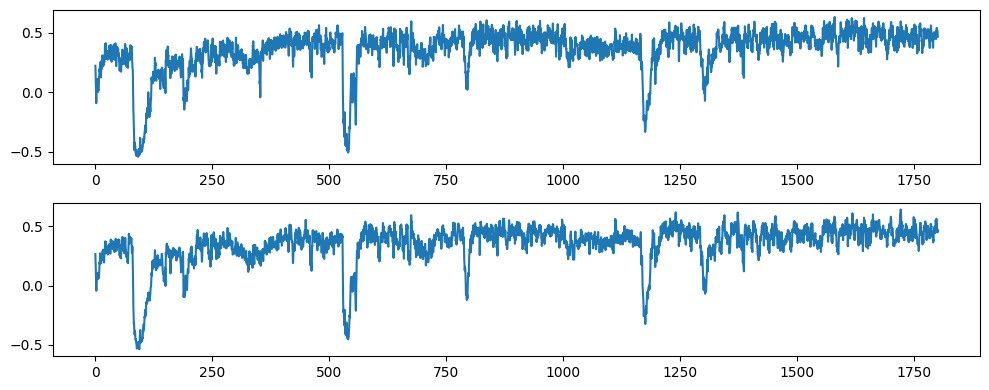

In [77]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4))

axes[0].plot(neural_df.time,neural_df.MBON21L)
axes[1].plot(neural_df.time,neural_df.MBON21R)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [78]:
neural_df['mean_MBON21'] = 0.5*(neural_df['MBON21L']+neural_df['MBON21R'])
neural_df['smoothed_MBON21'] = imaging_behavior_functions.apply_gaussian_smoothing(neural_df['mean_MBON21'],5)
MBON21_diff = np.diff(neural_df.smoothed_MBON21)
#plt.hist(MBON21_diff,bins=30)
# Determine the threshold for big drops (95th percentile)
threshold_low = np.percentile(MBON21_diff, 1)
threshold_high = np.percentile(MBON21_diff, 99)
# Identify indices where big drops occur
big_drop_indices = np.where(MBON21_diff <= threshold_low)[0]
big_increase_indices = np.where(MBON21_diff >= threshold_high)[0]

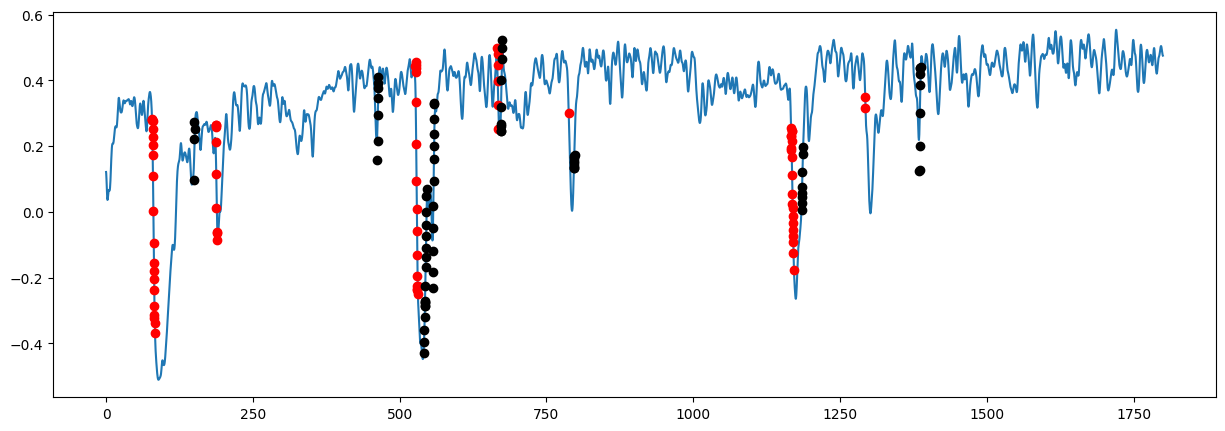

In [79]:
plt.figure(figsize=(15, 5))
plt.plot(neural_df.time, neural_df.smoothed_MBON21, label='Color Variable', zorder=1)
#plt.plot(neural_df.time[:-1], MBON21_diff)
# Highlighting the big drop indices in red
plt.scatter(neural_df.time[big_drop_indices], neural_df.mean_MBON21[big_drop_indices], color='red', label='Big Drops', zorder=2)
plt.scatter(neural_df.time[big_increase_indices], neural_df.mean_MBON21[big_increase_indices], color='black', label='Big Increases', zorder=2)


In [80]:
# Extract the first three PCs
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Time steps for coloring
phase = np.array(param_df.phase)
heading = 2*np.pi - np.array(behav_df.heading)
# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1[::4],
    y=pc2[::4],
    z=pc3[::4],
    mode='markers',
    marker=dict(
        size=5,
        color=phase[::4],  # Set color to time steps
        colorscale='Viridis',  # Choose a color scale
        colorbar=dict(title='Phase'),
        opacity=0.8
    )
)])

# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


In [81]:
# Extract the first three PCs
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Time steps for coloring
amplitude = np.array(param_df.amplitude)

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1[::4],
    y=pc2[::4],
    z=pc3[::4],
    mode='markers',
    marker=dict(
        size=5,
        color=amplitude[::4],  # Set color to time steps
        colorscale='Viridis',  # Choose a color scale
        colorbar=dict(title='Amplitude'),
        opacity=0.8
    )
)])

# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


In [82]:
# Extract the first three PCs
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Time steps for coloring
baseline = np.array(param_df.baseline)

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1[::2],
    y=pc2[::2],
    z=pc3[::2],
    mode='markers',
    marker=dict(
        size=4,
        color=baseline[::2],  # Set color to time steps
        colorscale='Viridis',  # Choose a color scale
        colorbar=dict(title='Baseline'),
        opacity=0.5
    )
)])

'''for idx in big_drop_indices:
    fig.add_trace(go.Scatter3d(x=pc1[idx:idx+2], y=pc2[idx:idx+2], z=pc3[idx:idx+2],
                               mode='lines',
                               line=dict(color='red', width=2)))

for idx in big_increase_indices:
    fig.add_trace(go.Scatter3d(x=pc1[idx:idx+2], y=pc2[idx:idx+2], z=pc3[idx:idx+2],
                               mode='lines',
                               line=dict(color='black', width=2)))'''    
# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


In [83]:
# Extract the first three PCs
pc1 = gaussian_filter1d(transformed_data[:, 0], sigma=10)
pc2 = gaussian_filter1d(transformed_data[:, 1],sigma=10)
pc3 = gaussian_filter1d(transformed_data[:, 2],sigma=10)

# Time steps for coloring
#lower_threshold = np.percentile(smoothed_df.fwV_smoothed, 5)
#upper_threshold = np.percentile(smoothed_df.fwV_smoothed, 95)
#color_var = np.abs(np.clip(smoothed_df.fwV_smoothed,lower_threshold, upper_threshold))
color_var = neural_df.time

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1,
    y=pc2,
    z=pc3,
    mode='markers',
    marker=dict(size=5, color=color_var, colorscale='Viridis')
)])

# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


In [84]:
padded_result_df.head(1)

Curvature_Mean  Curvature_Std  Tight_Turns  Moderate_Turns  Wide_Turns  \
0             NaN            NaN          NaN             NaN         NaN   

   Heading_Variance  Mean_fwV_sideV_Ratio  Yaw_Velocity_Mean  Yaw_Velocity_Std  
0               NaN                   NaN                NaN               NaN

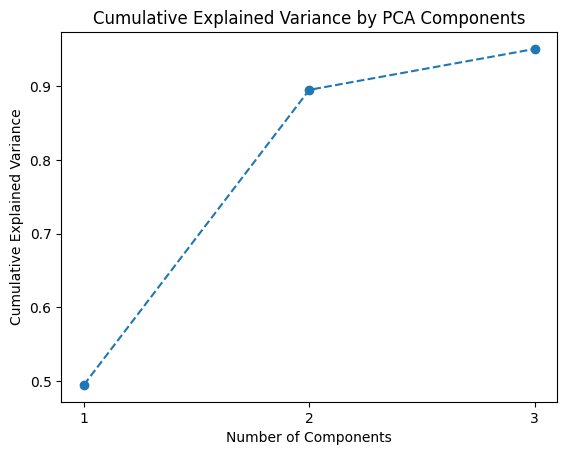

In [85]:
plt.plot(range(1, 4), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xticks(range(1, 4))
plt.show()

## Attempt 1: clustering (single behavioral var)

In [86]:
def perform_clustering(transformed_data, target_df, behavioral_variable, n_clusters=3):
    """
    Perform K-means clustering on combined neural PCs and a behavioral time series.

    Parameters:
    - neural_pcs: NumPy array or pandas DataFrame with the neural principal components.
    - behav_df: pandas DataFrame containing the behavioral time series.
    - behavioral_variable: string, the column name in behav_df for the behavioral time series.
    - n_clusters: int, the number of clusters to use in K-means.

    Returns:
    - Updates behav_df with a new column 'cluster_labels' containing the cluster labels.
    """
    
    # Ensure the behavioral variable is in the correct format and align lengths
    behavior_series = target_df[behavioral_variable].values.reshape(-1, 1)
    
    # Check if dimensions match
    if len(transformed_data) != len(behavior_series):
        raise ValueError("The lengths of neural PCs and behavioral data do not match.")
    
    # Combine neural PCs and behavioral variable
    combined_data = np.hstack((transformed_data, behavior_series))
    
    # Standardize the combined data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(combined_data)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(standardized_data)
    
    # Save cluster labels in behav_df
    target_df[behavioral_variable+'_labels'] = kmeans.labels_
    
    return target_df

# Example usage
# Assuming `neural_pcs` is your PCA components as a NumPy array or DataFrame
# and `behav_df` is your DataFrame with a column 'behavior_var' for the behavioral time series
perform_clustering(transformed_data, neural_df, 'MBON21R', n_clusters=7)

c:\Users\wilson\anaconda3\envs\2p_process\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



time   MBON21L   MBON21R  hDeltaB_0  hDeltaB_1  hDeltaB_2  \
0        0.000000  0.222773  0.264867   1.241962   0.383523   0.358444   
1        0.240513  0.209713  0.237666   1.122885   0.373910   0.261601   
2        0.481026  0.161754  0.212745   1.138844   0.295217   0.133648   
3        0.721539  0.086226  0.170872   1.136710   0.232473   0.008637   
4        0.962052  0.021611  0.116444   0.784412   0.284925  -0.013781   
...           ...       ...       ...        ...        ...        ...   
7480  1799.036986  0.495776  0.447953   0.220035  -0.130434   0.015037   
7481  1799.277499  0.477877  0.464794   0.021527  -0.090348  -0.056911   
7482  1799.518012  0.477426  0.469343  -0.275158  -0.050738  -0.134345   
7483  1799.758525  0.468498  0.453946  -0.411082  -0.063065  -0.065458   
7484  1799.999038  0.467024  0.458304  -0.380608  -0.101228   0.033184   

      hDeltaB_3  hDeltaB_4  hDeltaB_5  hDeltaB_6  ...  hDeltaB_21  hDeltaB_22  \
0      0.097757   0.011519   0.277770   0.061169  ...    2.162483    1.916930   
1      0.186200   0.079669   0.205932   0.085467  ...    2.076988    1.878382   
2      0.338941   0.132484   0.163215   0.189639  ...    2.052068    1.858321   
3      0.368918   0.121838   0.228631   0.317409  ...    2.116092    1.876195   
4      0.299948   0.062412   0.358765   0.385596  ...    2.166246    1.901164   
...         ...        ...        ...        ...  ...         ...         ...   
7480  -0.042719  -0.123742  -0.077967   0.034825  ...    1.894932    1.306142   
7481  -0.082641  -0.201801  -0.158782   0.034147  ...    2.100247    1.446980   
7482  -0.031096  -0.246961  -0.211673  -0.003561  ...    2.300975    1.788475   
7483   0.032444  -0.249648  -0.194095  -0.061058  ...    2.458006    2.080824   
7484   0.078122  -0.192836  -0.134129  -0.140061  ...    2.538869    2.150089   

      hDeltaB_23  hDeltaB_24  hDeltaB_25  hDeltaB_26  hDeltaB_27  mean_MBON21  \
0       1.971367    1.724920    1.422568    1.198348    1.322129     0.243820   
1       2.054740    1.769468    1.327635    1.199988    1.461048     0.223690   
2       2.050991    1.830000    1.274174    1.266786    1.564603     0.187249   
3       1.937832    1.814542    1.178010    1.355249    1.511653     0.128549   
4       1.879810    1.712413    1.057092    1.345140    1.334321     0.069028   
...          ...         ...         ...         ...         ...          ...   
7480    1.125682    0.694187    0.191132    0.156214    0.164683     0.471865   
7481    1.464223    0.892807    0.474159    0.244738    0.307505     0.471335   
7482    1.732115    1.079645    0.681985    0.223644    0.445096     0.473385   
7483    1.906719    1.199272    0.745784    0.225406    0.542416     0.461222   
7484    1.915252    1.251827    0.720534    0.248897    0.503591     0.462664   

      smoothed_MBON21  MBON21R_labels  
0            0.121589               1  
1            0.117588               1  
2            0.110009               1  
3            0.099642               1  
4            0.087539               1  
...               ...             ...  
7480         0.482541               6  
7481         0.479902               6  
7482         0.477807               6  
7483         0.476357               1  
7484         0.475615               1  

[7485 rows x 34 columns]

In [87]:
pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]
pc3 = transformed_data[:, 2]

# Time steps for coloring
#lower_threshold = np.percentile(smoothed_df.fwV_smoothed, 5)
#upper_threshold = np.percentile(smoothed_df.fwV_smoothed, 95)
#color_var = np.abs(np.clip(smoothed_df.fwV_smoothed,lower_threshold, upper_threshold))
color_var = neural_df.MBON21R_labels

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=pc1[::4],
    y=pc2[::4],
    z=pc3[::4],
    mode='markers',
    marker=dict(
        size=5,
        color=color_var[::4],  # Set color to time steps
        colorscale='hot',  # Choose a color scale
        colorbar=dict(title='Cluster Label'),
        opacity=0.8
    )
)])

# Set the layout of the figure
fig.update_layout(
    title='Trajectory of the First 3 Principal Components in State Space',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the figure
fig.show()


## Behavior

In [88]:
imaging_behavior_functions.plot_fly_traj(behav_df.xPos,behav_df.yPos,behav_df,'odor',example_path_results,1)